In [21]:
import pandas as pd, numpy as np
import seaborn as sns
import torch
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
from skimage.color import rgb2gray
from skimage.filters import sobel, scharr, apply_hysteresis_threshold, gaussian
from skimage.feature import canny
from skimage.measure import regionprops,regionprops_table
from skimage.morphology import binary_opening, disk, binary_closing, binary_dilation, binary_erosion
from skimage.draw import rectangle_perimeter
from sklearn.model_selection import train_test_split
from scipy.ndimage import label as scilabel
import cv2
import matplotlib; matplotlib.rcParams['figure.dpi']=300
# make sure pytorch is installed
# see this tutorial: https://github.com/jlevy44/medstudent_resident_informatics_tutorials/blob/main/1_image_analysis/1_image_analysis.ipynb

# Load cell data

In [22]:
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]

In [23]:
urothelial_cells.keys()
#print shape
print(images.shape)
print(urothelial_cells["X"].shape)
print(urothelial_cells["y"].shape)


(200, 256, 256, 3)
torch.Size([200, 3, 256, 256])
(200, 256, 256)


In [24]:
idx_image=1
img=images[idx_image]



(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

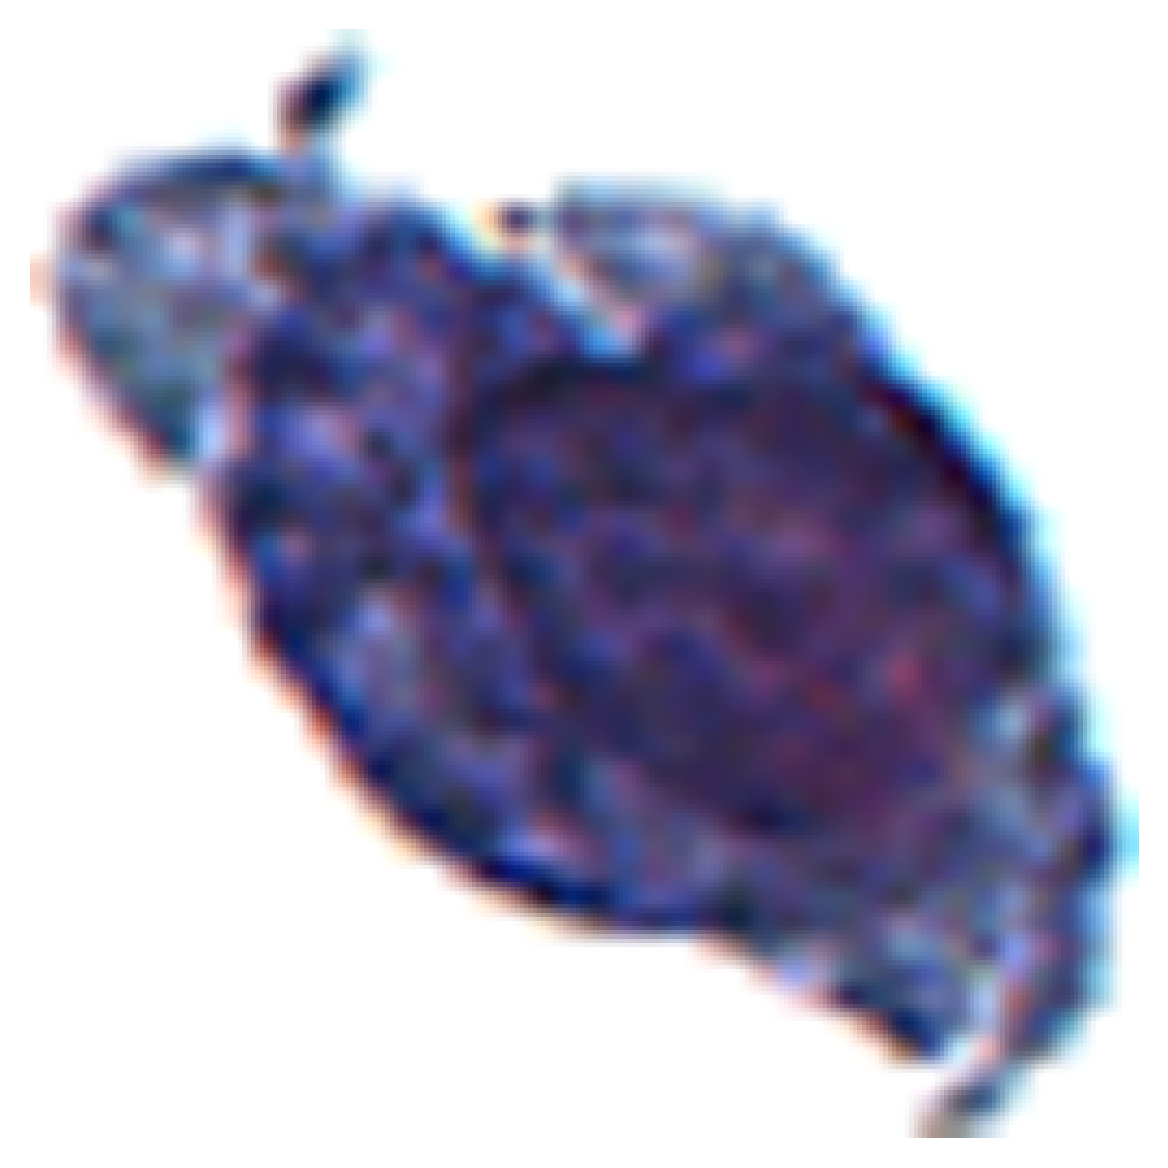

In [25]:
plt.imshow(img)
plt.axis("off")
#plot respective segmentation mask in the y column


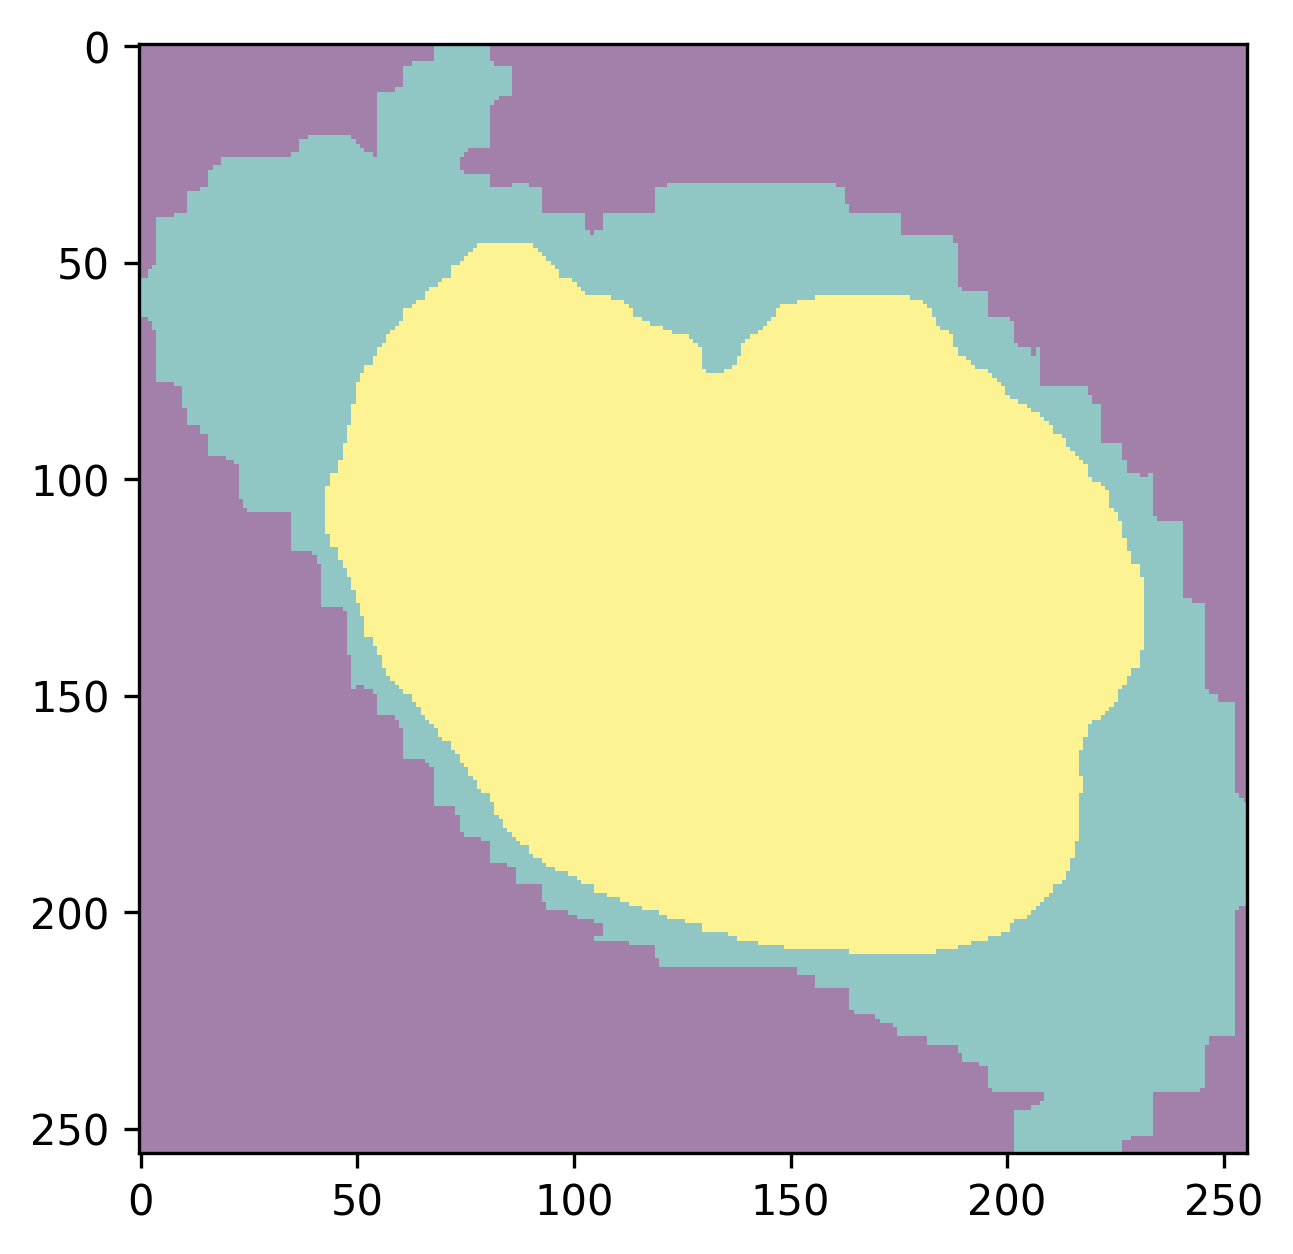

In [26]:
plt.imshow(labels[idx_image],alpha=0.5)

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

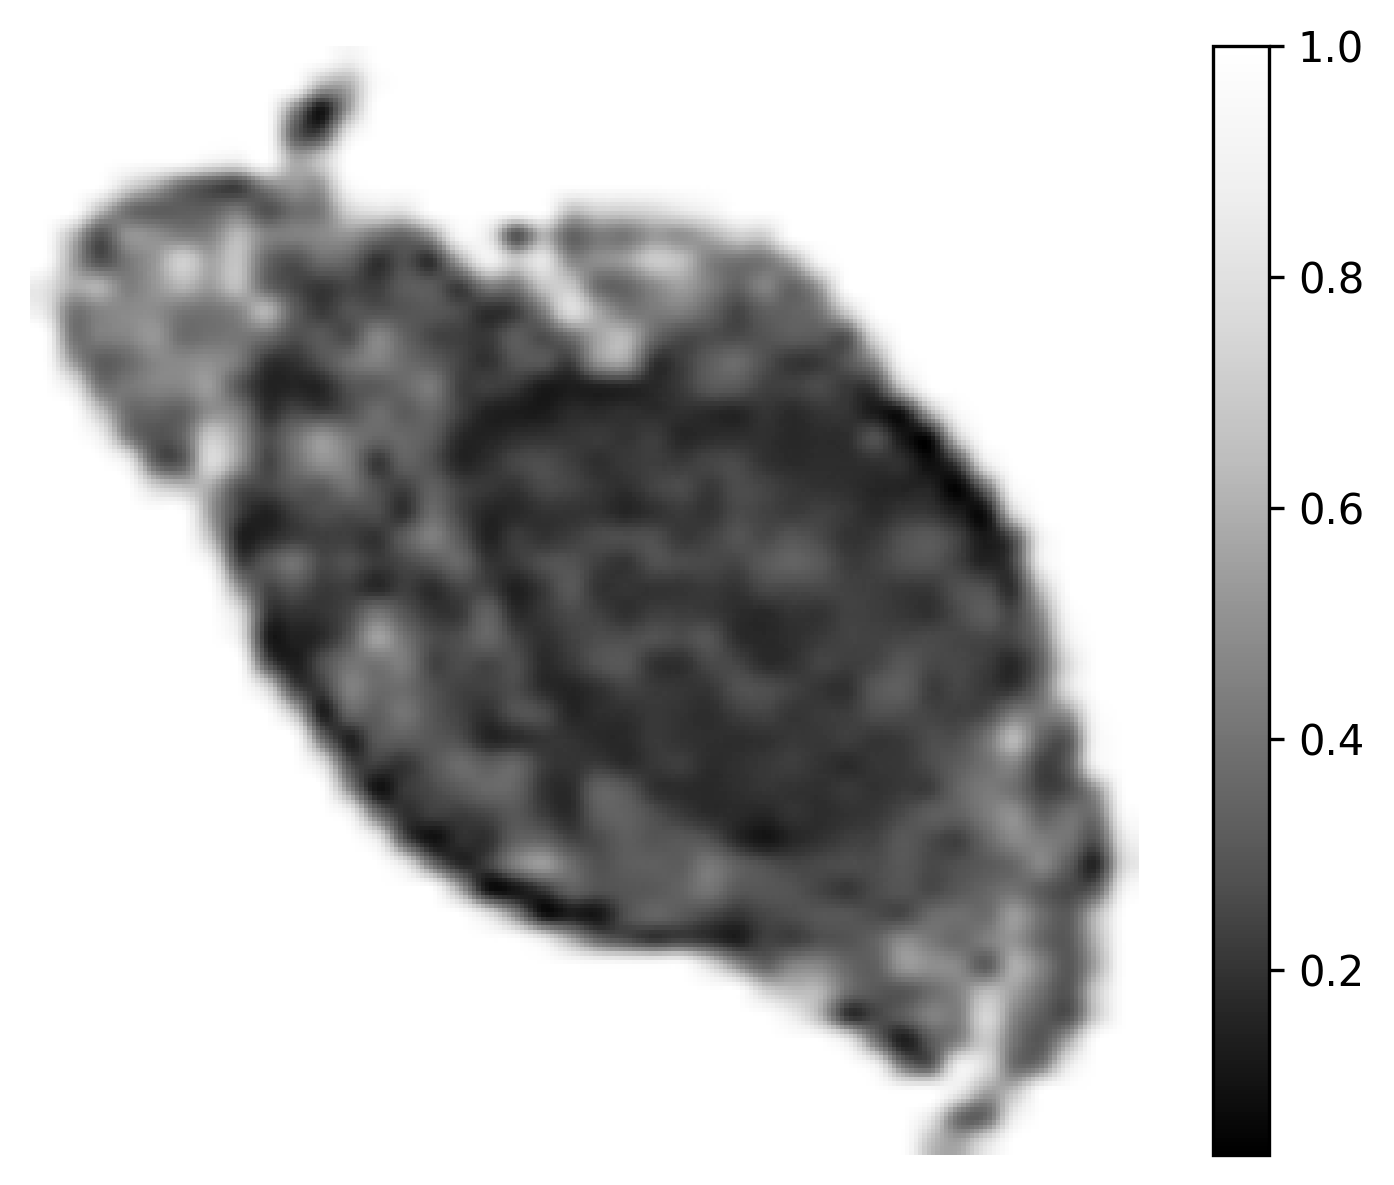

In [27]:
img_gray=rgb2gray(img)
plt.imshow(img_gray,cmap="Greys_r")
plt.colorbar()
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

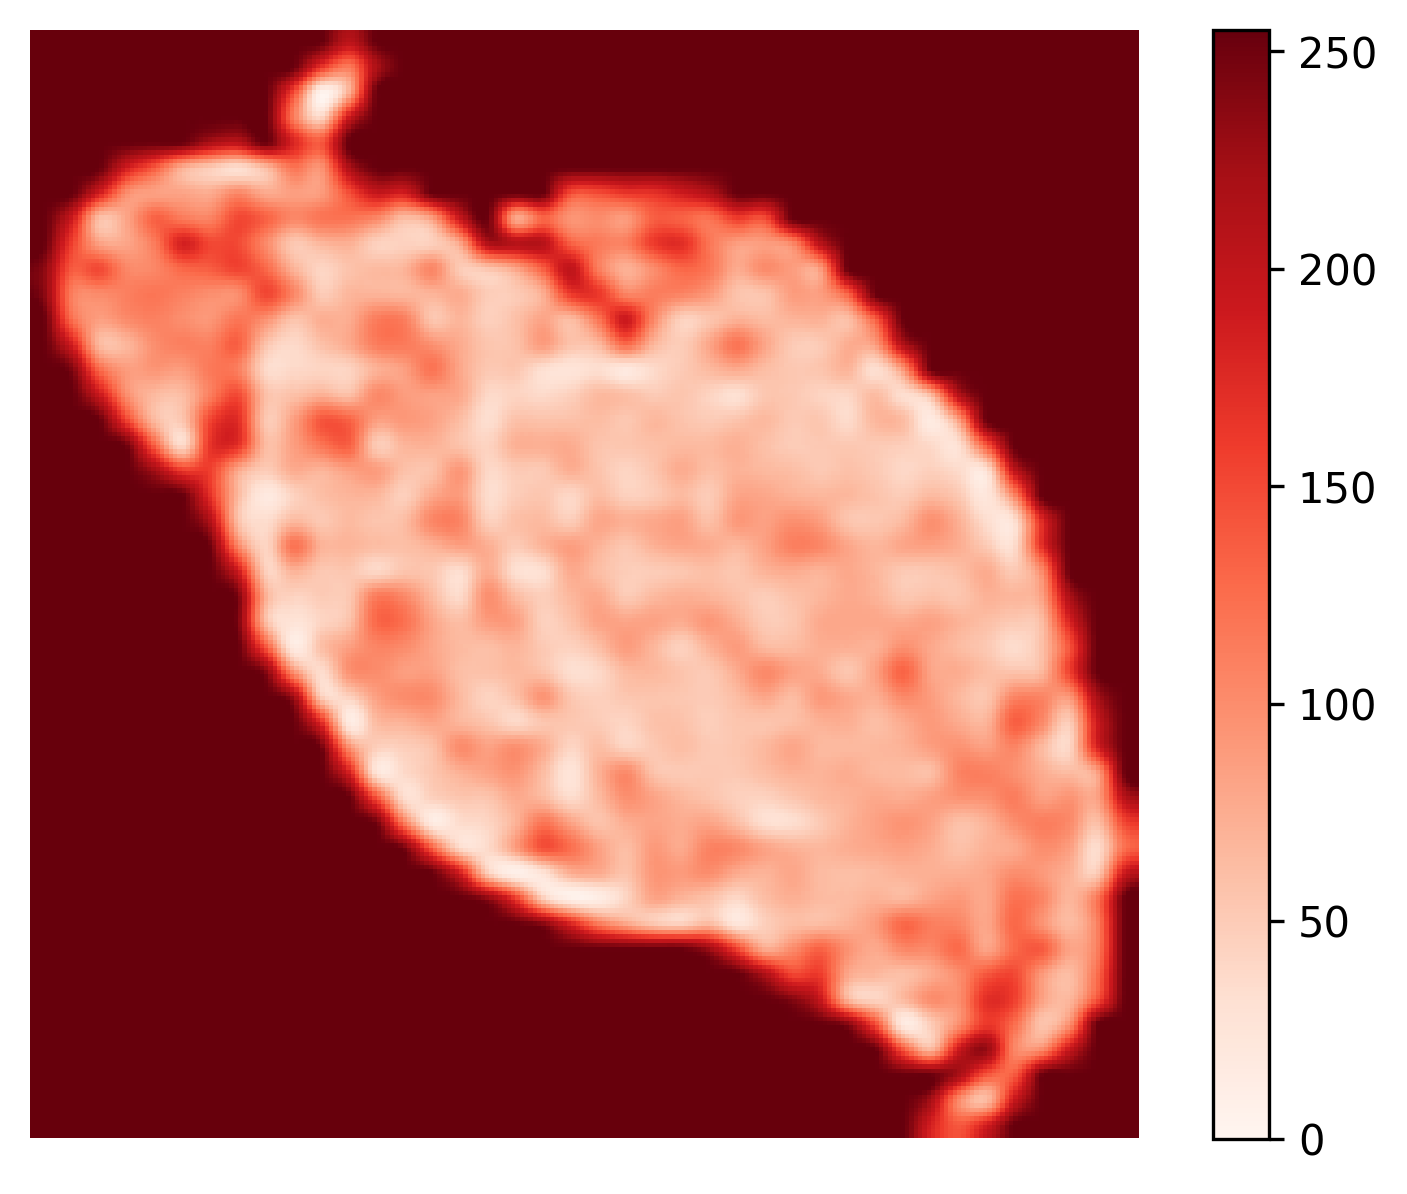

In [28]:
plt.imshow(img[...,0],cmap="Reds")
plt.colorbar()
plt.axis("off")

(array([  463.,  9956., 10794.,  5152.,  3323.,  1891.,  1357.,  1100.,
         1237., 30263.]),
 array([0.03948824, 0.13553941, 0.23159059, 0.32764176, 0.42369294,
        0.51974412, 0.61579529, 0.71184647, 0.80789765, 0.90394882,
        1.        ]),
 <BarContainer object of 10 artists>)

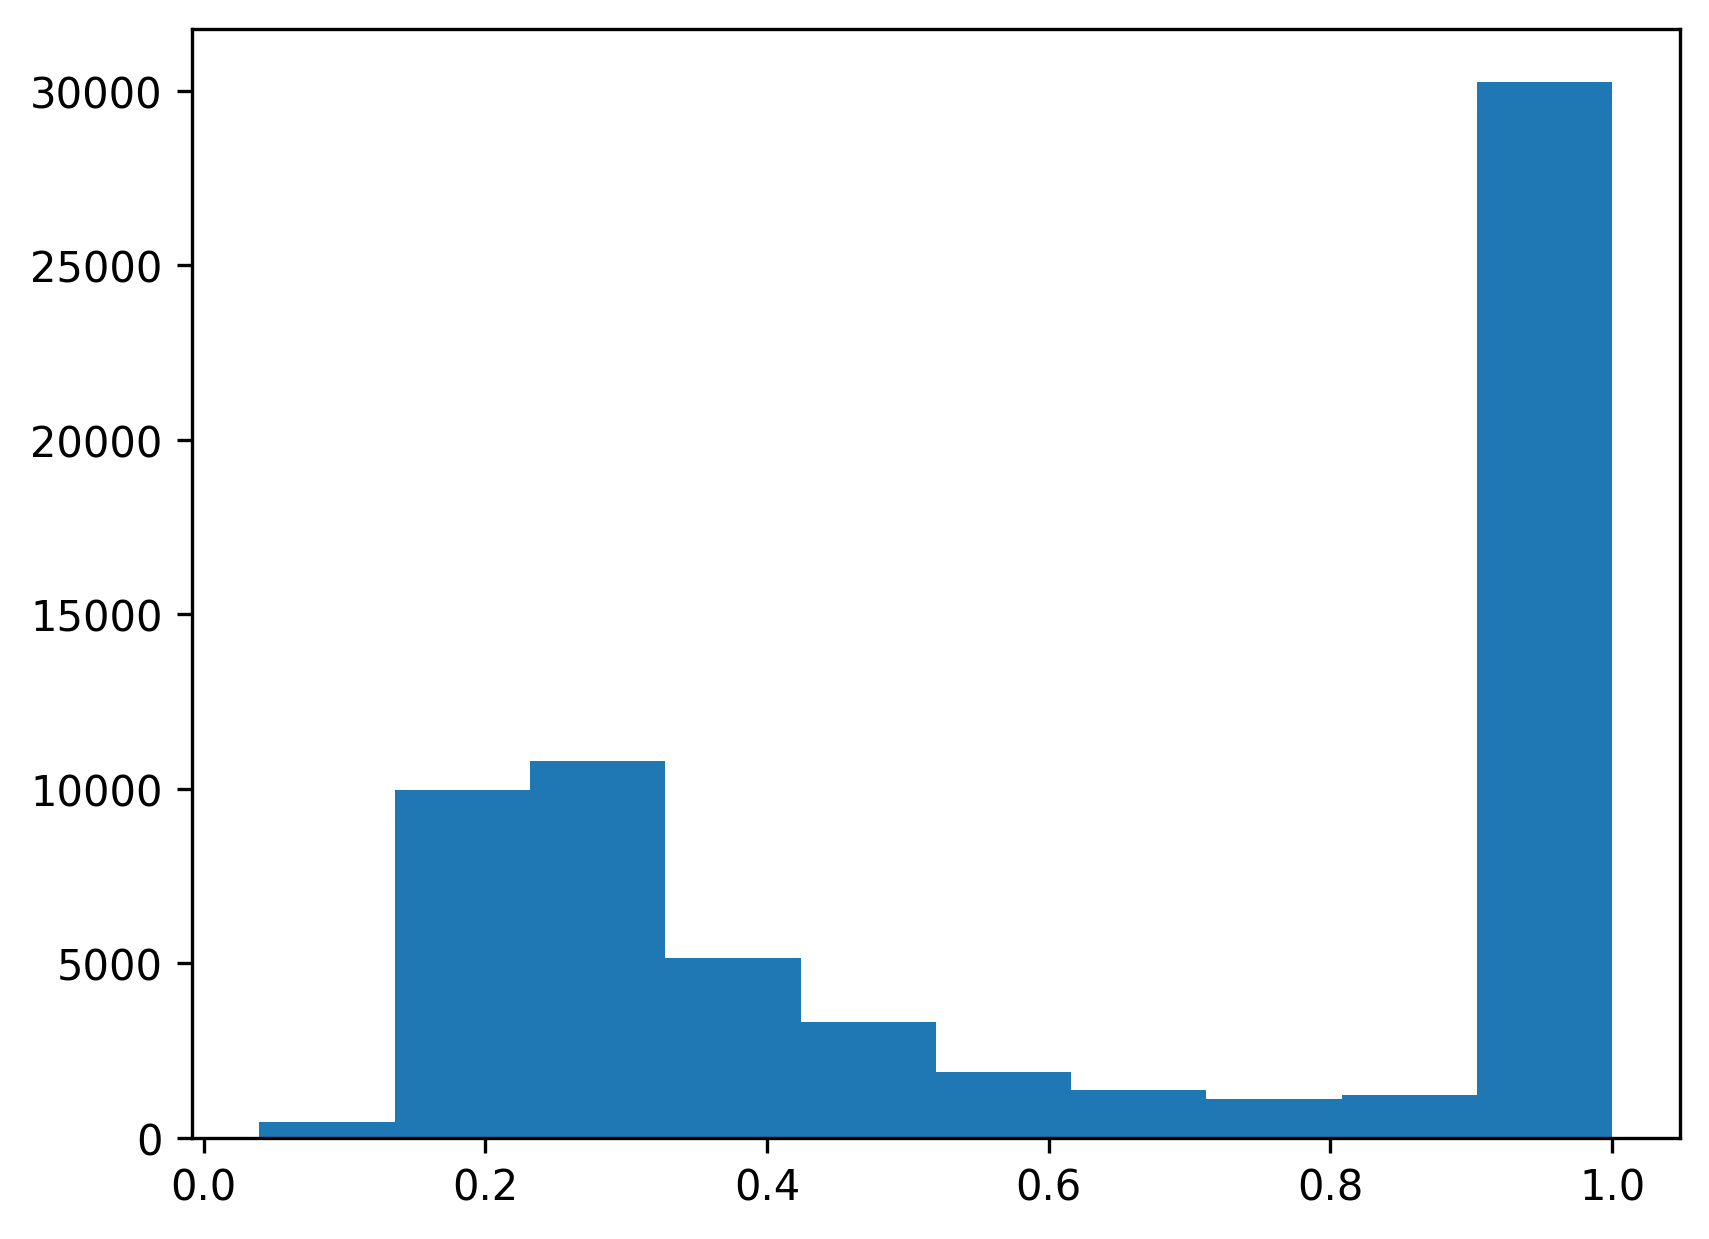

In [29]:
plt.hist(img_gray.flatten())

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

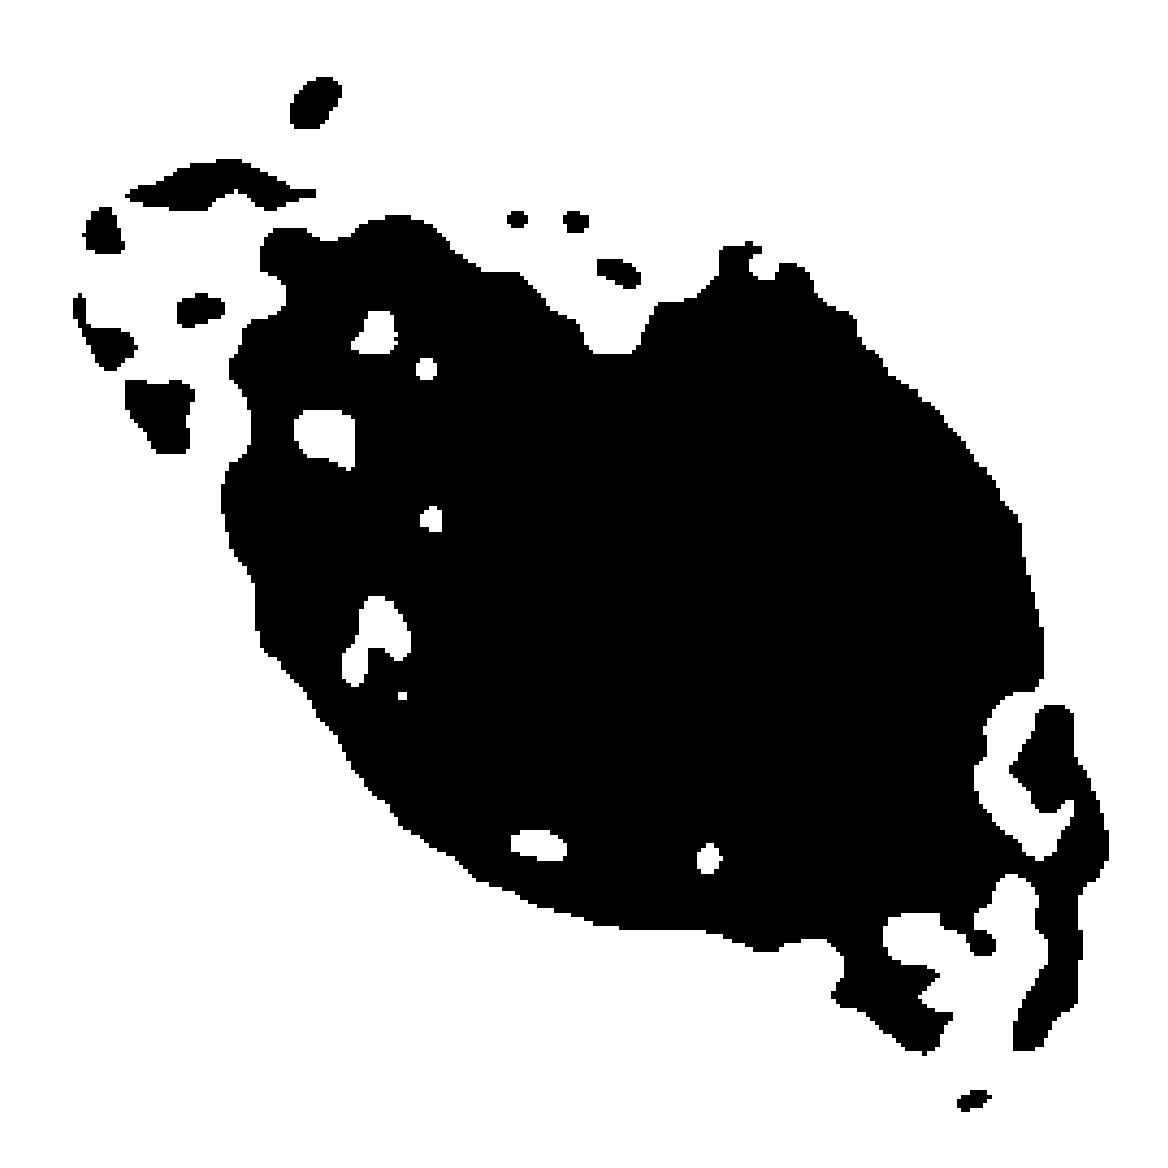

In [30]:
nucleus=img_gray<0.4
plt.imshow(nucleus,cmap="Greys")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

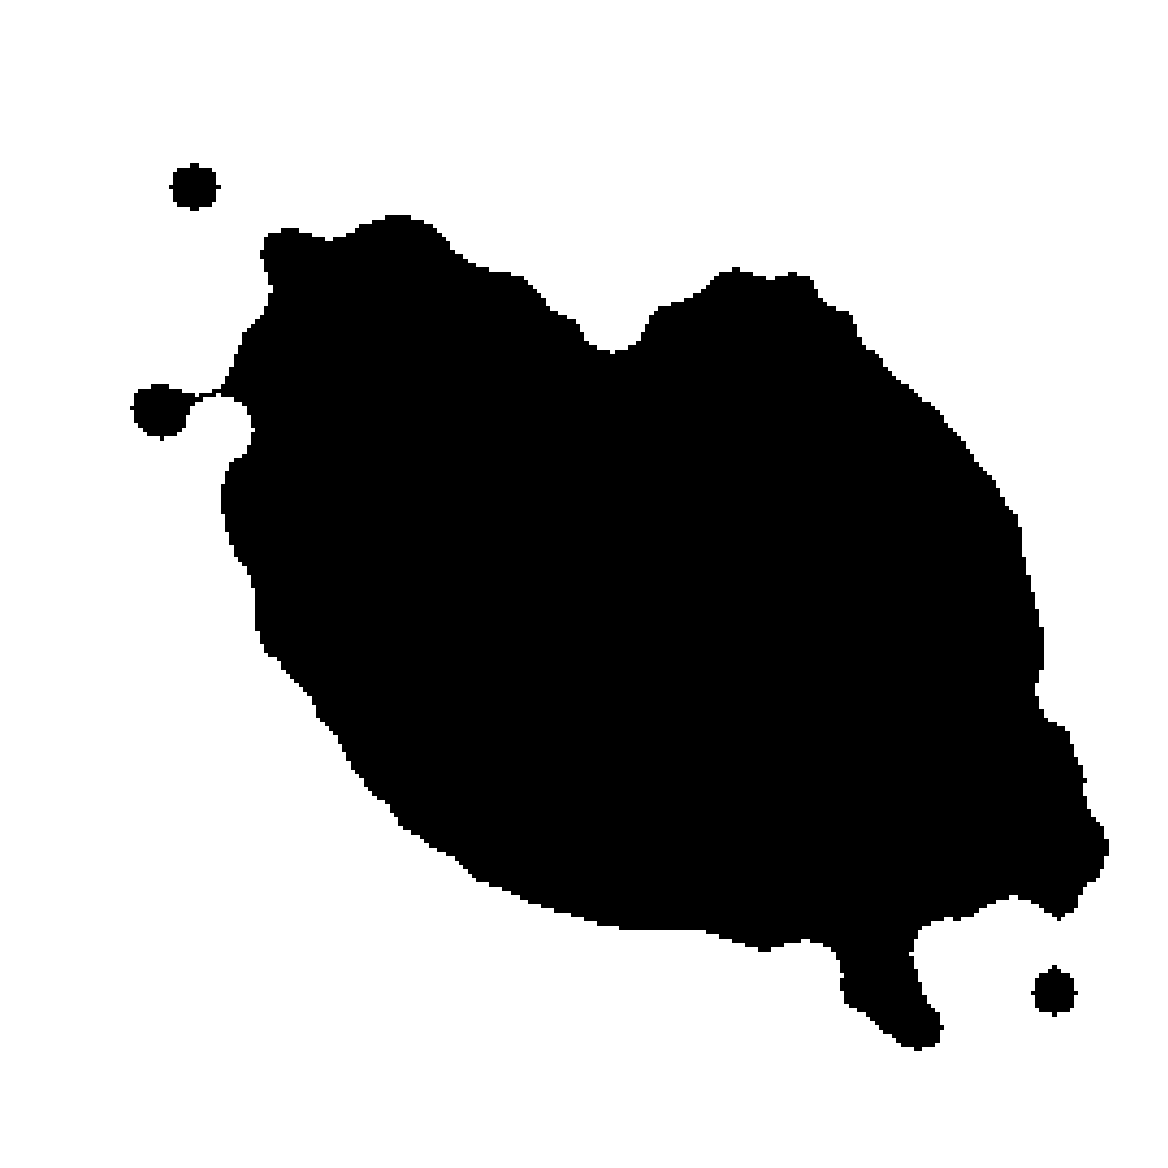

In [31]:
nucleus=img_gray<0.4
nucleus=binary_opening(nucleus,disk(5))
nucleus=binary_closing(nucleus,disk(8))
plt.imshow(nucleus,cmap="Greys")
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

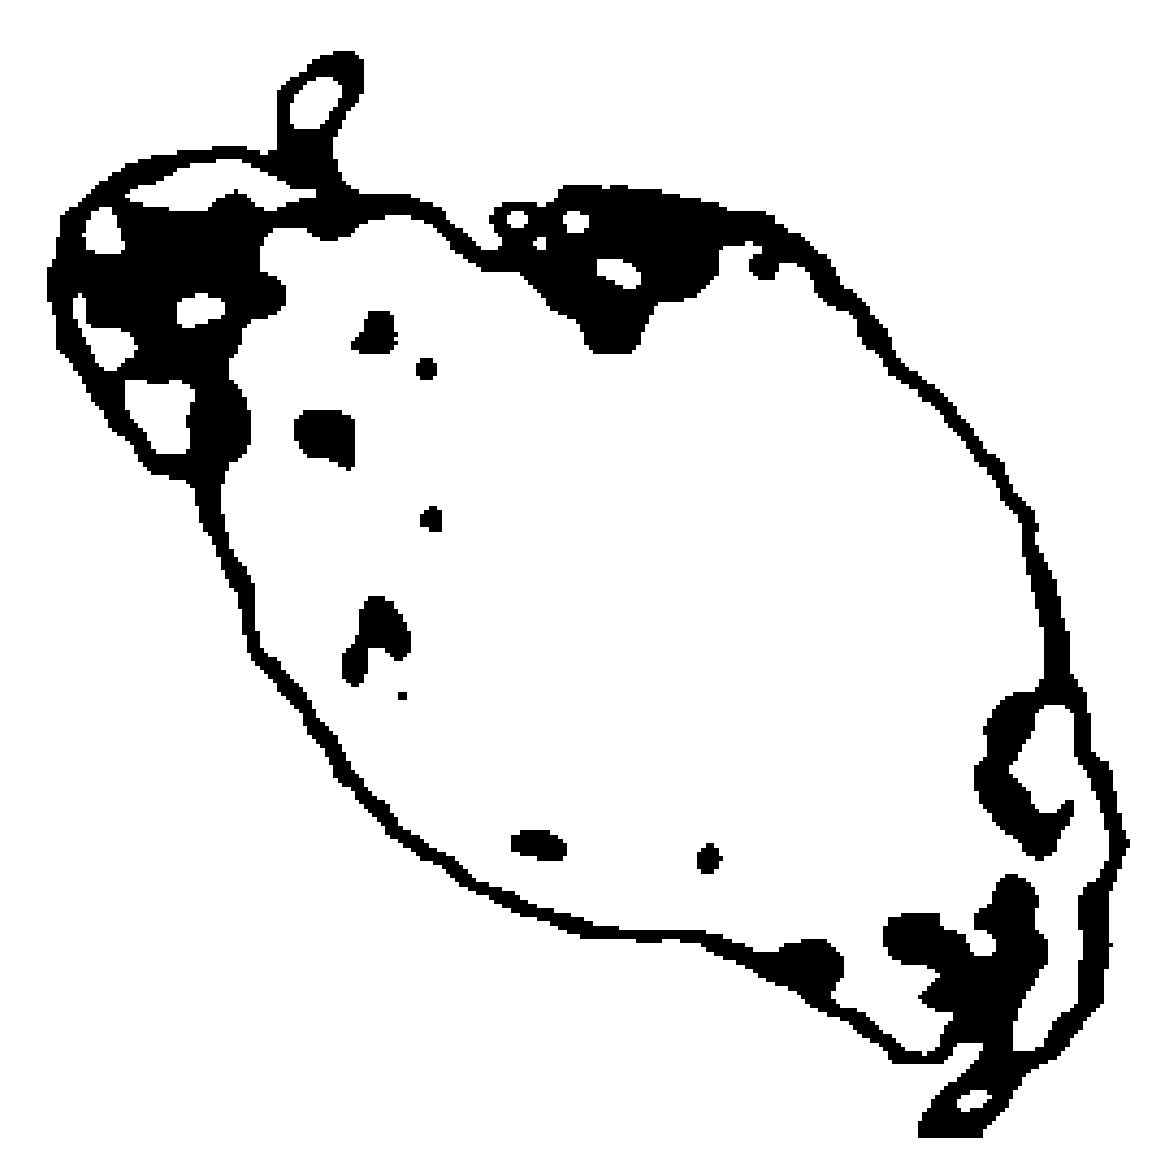

In [32]:
cytoplasm=np.logical_and(img_gray>=0.4,img_gray<=0.8)
plt.imshow(cytoplasm,cmap="Greys")
plt.axis("off")

In [33]:
nc_ratio_pred=nucleus.sum()/(nucleus.sum()+cytoplasm.sum())


In [34]:
segmentation_mask=labels[idx_image]

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

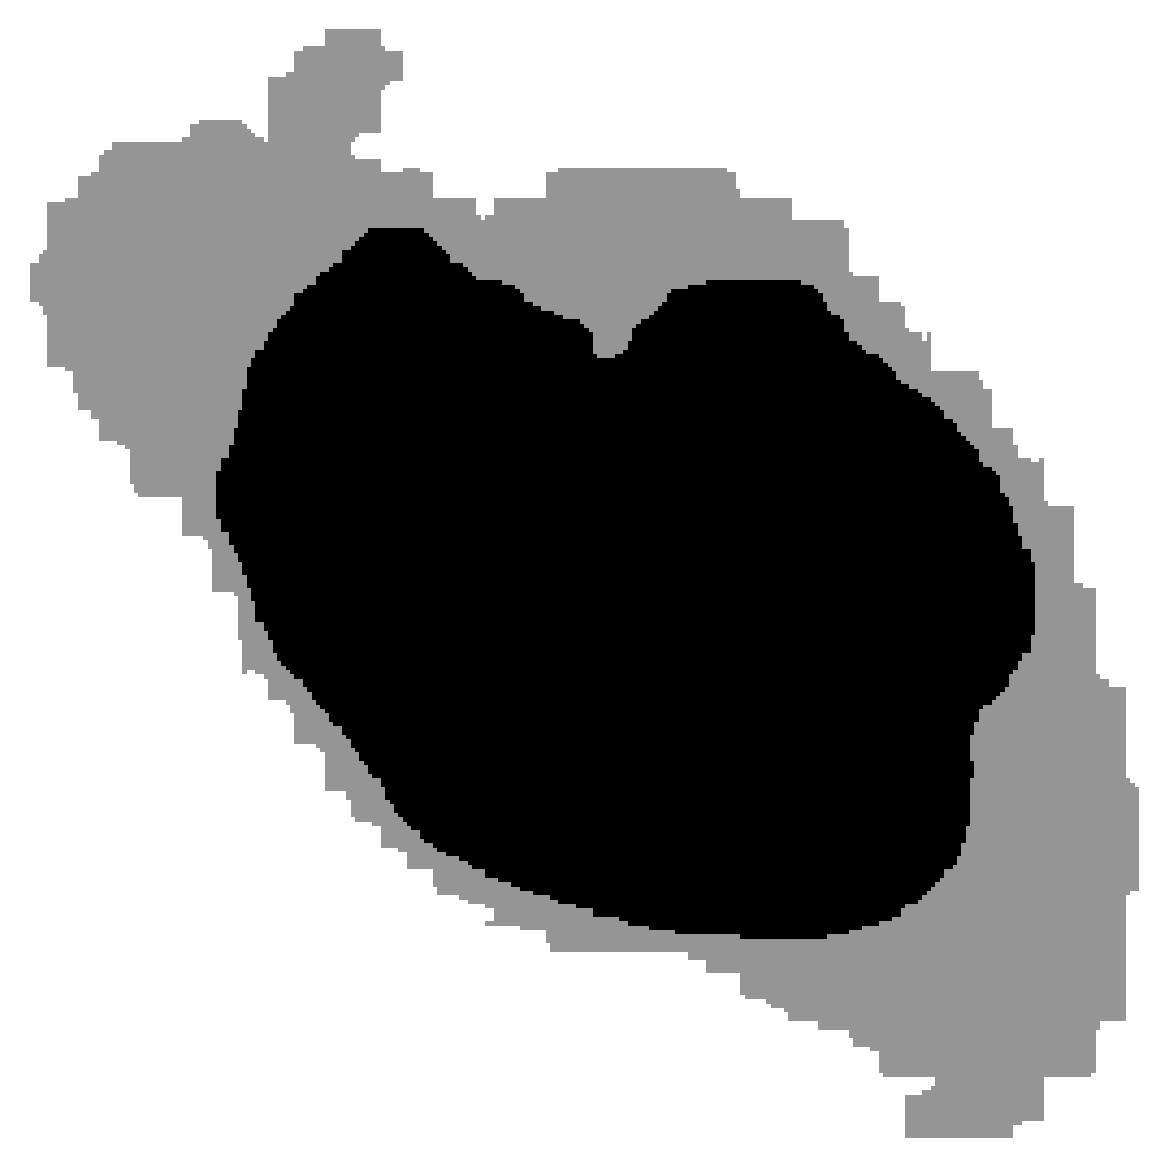

In [35]:
plt.imshow(segmentation_mask,cmap="Greys")
plt.axis("off")

In [36]:
cytoplasm_true=(segmentation_mask==1)
nucleus_true=(segmentation_mask==2)
nc_ratio_true=nucleus_true.sum()/(nucleus_true.sum()+cytoplasm_true.sum())


In [37]:
nc_ratio_true,nc_ratio_pred


(np.float64(0.5972044387537345), np.float64(0.7440235814296242))

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

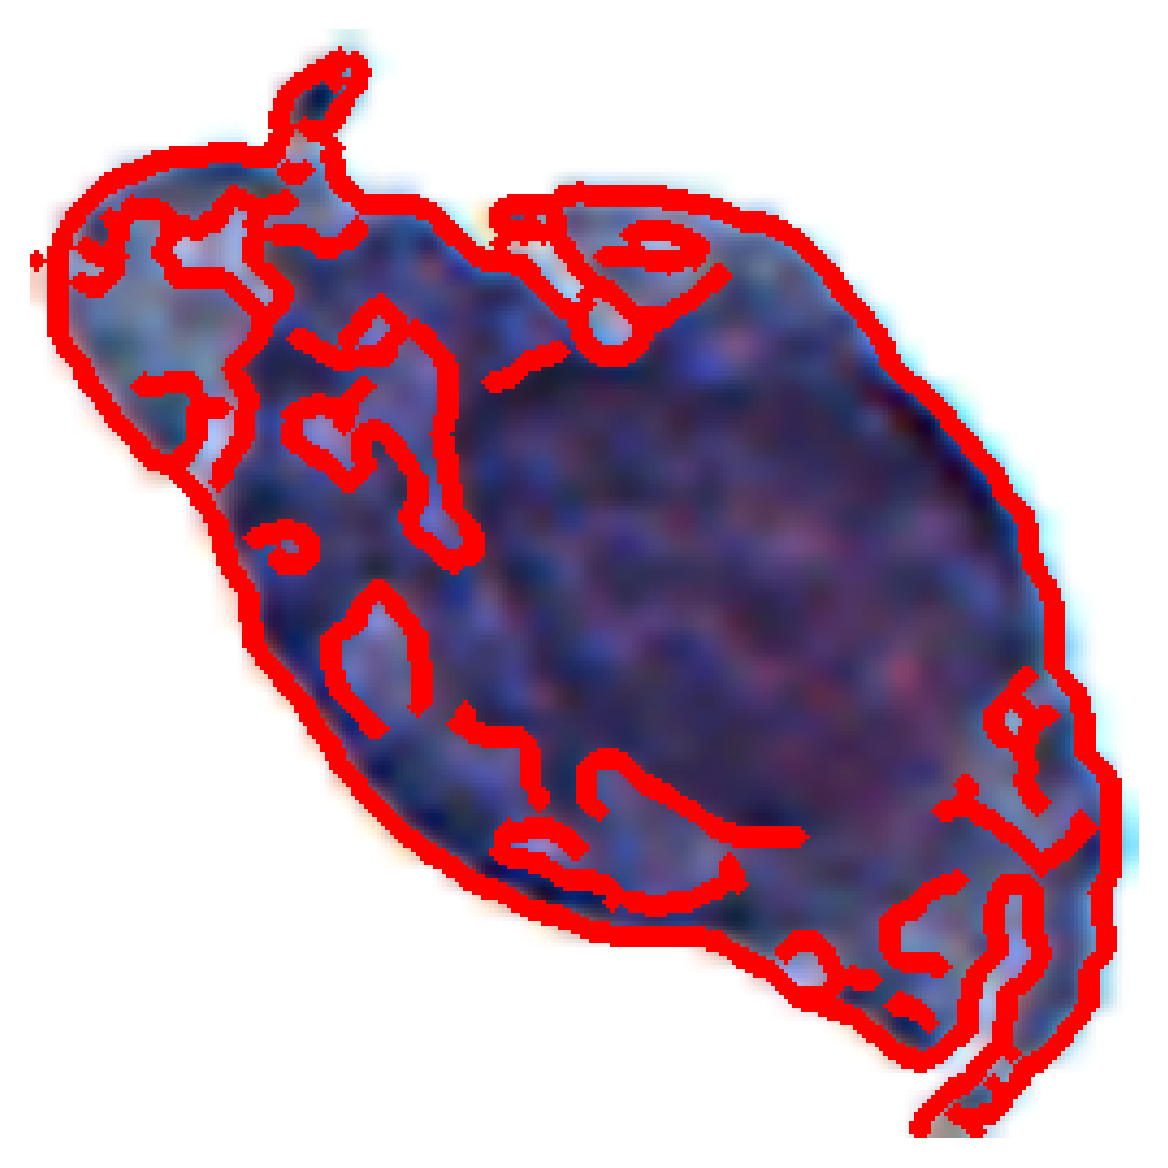

In [38]:
edges=binary_dilation(canny(img_gray, sigma=2.),disk(2))
img_new=img.copy()
img_new[edges]=[255,0,0]
plt.imshow(img_new)
plt.axis("off")

# Generate labels for deep learning analysis

In [39]:
X = urothelial_cells["X"].numpy()  # (200, 3, 256, 256)
Y = urothelial_cells["y"]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = torch.FloatTensor(X_train)  # (N, C, H, W)
X_val = torch.FloatTensor(X_val)
Y_train = torch.LongTensor(Y_train)  # (N, 1, H, W)
Y_val = torch.LongTensor(Y_val)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}")  # Expected: (160, 3, 256, 256)
print(f"Y_train shape: {Y_train.shape}")  # Expected: (160, 256, 256)
print(f"X_val shape: {X_val.shape}") 

X_train shape: torch.Size([160, 3, 256, 256])
Y_train shape: torch.Size([160, 256, 256])
X_val shape: torch.Size([40, 3, 256, 256])


In [ ]:
import time
from semseg_functions import train_model,make_predictions
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import classification_report

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

start_time = time.time()
model, best_model_loss=train_model(X_train,Y_train,X_val,Y_val)
end_time = time.time()
print("Total training time:", end_time-start_time)
y_val_pred=make_predictions(X_val,model=None)
y_val_pred_lbls=y_val_pred.argmax(1)
print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))
print("Val loss:", best_model_loss)

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Flatten prediction: shape (B, C, H, W) to (N, C)
y_val_pred_flat = y_val_pred.transpose(0, 2, 3, 1).reshape(-1, y_val_pred.shape[1])

# Flatten true labels: shape (B, H, W) to (N,)
y_true = Y_val.numpy().flatten()

# Binarize true labels for multiclass AUROC
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

# Compute AUROC
auroc = roc_auc_score(y_true_binarized, y_val_pred_flat, multi_class='ovr')

print("AUROC:", auroc)



c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


X_train shape: torch.Size([160, 3, 256, 256])
Y_train shape: torch.Size([160, 256, 256])
Using device: cuda
Training: Epoch 1, Batch 0, Loss: 1.25
Training: Epoch 1, Batch 1, Loss: 1.038
Training: Epoch 1, Batch 2, Loss: 0.999
Training: Epoch 1, Batch 3, Loss: 0.982
Training: Epoch 1, Batch 4, Loss: 0.992
Training: Epoch 1, Batch 5, Loss: 0.751
Training: Epoch 1, Batch 6, Loss: 0.816
Training: Epoch 1, Batch 7, Loss: 0.757
Training: Epoch 1, Batch 8, Loss: 0.944
Training: Epoch 1, Batch 9, Loss: 0.663
Training: Epoch 1, Batch 10, Loss: 0.592
Training: Epoch 1, Batch 11, Loss: 0.871
Training: Epoch 1, Batch 12, Loss: 0.714
Training: Epoch 1, Batch 13, Loss: 0.719
Training: Epoch 1, Batch 14, Loss: 0.719
Training: Epoch 1, Batch 15, Loss: 0.649
Training: Epoch 1, Batch 16, Loss: 0.586
Training: Epoch 1, Batch 17, Loss: 0.536
Training: Epoch 1, Batch 18, Loss: 0.604
Training: Epoch 1, Batch 19, Loss: 0.637
Val: Epoch 1, Loss: 1.146
Training: Epoch 2, Batch 0, Loss: 0.51
Training: Epoch 2,

c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_l

Loading model from: ./seg_models/bestunet_model.pkl
              precision    recall  f1-score   support

           0       0.93      0.98      0.96    937035
           1       0.94      0.81      0.87   1187442
           2       0.74      0.90      0.81    496963

    accuracy                           0.89   2621440
   macro avg       0.87      0.90      0.88   2621440
weighted avg       0.90      0.89      0.89   2621440

Training loss: 0.2769550234079361
AUROC: 0.9773081837856911


In [41]:
from semseg_functions import train_model_transunet, make_predictions_transunet
from transunet import TransUNet
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import classification_report


#model = TransUNet()

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

#X_train,Y_train,X_val,Y_val=load_imgs_labels()
start_time = time.time()
model, best_model_loss=train_model_transunet(X_train,Y_train,X_val,Y_val, lr= 0.003, momentum= 0.9, weight_decay= 0.01)
end_time = time.time()
print("Total training time:", end_time-start_time)
y_val_pred=make_predictions_transunet(X_val,model=None)
y_val_pred_lbls=y_val_pred.argmax(1)
print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))
#print loss
print("Val loss:", best_model_loss)

# Flatten prediction: shape (B, C, H, W) → (N, C)
y_val_pred_flat = y_val_pred.transpose(0, 2, 3, 1).reshape(-1, y_val_pred.shape[1])

# Flatten true labels: shape (B, H, W) → (N,)
y_true = Y_val.numpy().flatten()

# Binarize true labels for multiclass AUROC
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

# Compute AUROC
auroc = roc_auc_score(y_true_binarized, y_val_pred_flat, multi_class='ovr')

print("AUROC:", auroc)


X_train shape: torch.Size([160, 3, 256, 256])
Y_train shape: torch.Size([160, 256, 256])
Using device: cuda
Training: Epoch 1, Batch 0, Loss: 1.109
Training: Epoch 1, Batch 1, Loss: 1.107
Training: Epoch 1, Batch 2, Loss: 1.106
Training: Epoch 1, Batch 3, Loss: 1.102
Training: Epoch 1, Batch 4, Loss: 1.099
Training: Epoch 1, Batch 5, Loss: 1.103
Training: Epoch 1, Batch 6, Loss: 1.093
Training: Epoch 1, Batch 7, Loss: 1.097
Training: Epoch 1, Batch 8, Loss: 1.092
Training: Epoch 1, Batch 9, Loss: 1.085
Training: Epoch 1, Batch 10, Loss: 1.087
Training: Epoch 1, Batch 11, Loss: 1.085
Training: Epoch 1, Batch 12, Loss: 1.078
Training: Epoch 1, Batch 13, Loss: 1.077
Training: Epoch 1, Batch 14, Loss: 1.068
Training: Epoch 1, Batch 15, Loss: 1.073
Training: Epoch 1, Batch 16, Loss: 1.069
Training: Epoch 1, Batch 17, Loss: 1.064
Training: Epoch 1, Batch 18, Loss: 1.055
Training: Epoch 1, Batch 19, Loss: 1.057
Val: Epoch 1, Loss: 1.074
Training: Epoch 2, Batch 0, Loss: 1.059
Training: Epoch 

c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_l

Loading model from: ./seg_models\best_transunet_model.pkl
              precision    recall  f1-score   support

           0       0.99      0.94      0.96    937035
           1       0.91      0.90      0.90   1187442
           2       0.80      0.90      0.85    496963

    accuracy                           0.91   2621440
   macro avg       0.90      0.91      0.90   2621440
weighted avg       0.92      0.91      0.91   2621440

Val loss: 0.21520392894744872
AUROC: 0.9848283707237656


In [42]:
import importlib
import sys
from semseg_functions import train_model_transunet, make_predictions_transunet, train_model_transunet_sweep
importlib.reload(sys.modules["semseg_functions"])
from semseg_functions import train_model_transunet, make_predictions_transunet, train_model_transunet_sweep
from augment_train import augment_train
importlib.reload(sys.modules["augment_train"])
from augment_train import augment_train
from transunet import TransUNet
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import classification_report



#model = TransUNet()

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train_aug, Y_train_aug = augment_train(X_train, Y_train, augment_times=2)

print("X_train_aug shape:", X_train_aug.shape)
print("Y_train_aug shape:", Y_train_aug.shape)

#X_train,Y_train,X_val,Y_val=load_imgs_labels()
#model=train_model_transunet(X_train,Y_train,X_val,Y_val)
start_time = time.time()
model, best_model_loss=train_model_transunet(X_train_aug,Y_train_aug,X_val,Y_val, lr= 0.003, momentum= 0.9, weight_decay= 0.01)
end_time = time.time()
print("Total training time:", end_time-start_time)
y_val_pred=make_predictions_transunet(X_val,model=None)
y_val_pred_lbls=y_val_pred.argmax(1)
print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))
#print loss
print("Training loss:", best_model_loss)


X_train shape: torch.Size([160, 3, 256, 256])
Y_train shape: torch.Size([160, 256, 256])


c:\Python312\Lib\site-packages\torch\nn\functional.py:4969: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\Python312\Lib\site-packages\torch\nn\functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Augmented X shape: torch.Size([480, 3, 256, 256]), Augmented Y shape: torch.Size([480, 256, 256])
X_train_aug shape: torch.Size([480, 3, 256, 256])
Y_train_aug shape: torch.Size([480, 256, 256])
Using device: cuda
Training: Epoch 1, Batch 0, Loss: 1.113
Training: Epoch 1, Batch 1, Loss: 1.099
Training: Epoch 1, Batch 2, Loss: 1.106
Training: Epoch 1, Batch 3, Loss: 1.099
Training: Epoch 1, Batch 4, Loss: 1.097
Training: Epoch 1, Batch 5, Loss: 1.091
Training: Epoch 1, Batch 6, Loss: 1.08
Training: Epoch 1, Batch 7, Loss: 1.081
Training: Epoch 1, Batch 8, Loss: 1.084
Training: Epoch 1, Batch 9, Loss: 1.08
Training: Epoch 1, Batch 10, Loss: 1.085
Training: Epoch 1, Batch 11, Loss: 1.09
Training: Epoch 1, Batch 12, Loss: 1.076
Training: Epoch 1, Batch 13, Loss: 1.061
Training: Epoch 1, Batch 14, Loss: 1.072
Training: Epoch 1, Batch 15, Loss: 1.067
Training: Epoch 1, Batch 16, Loss: 1.069
Training: Epoch 1, Batch 17, Loss: 1.052
Training: Epoch 1, Batch 18, Loss: 1.041
Training: Epoch 1, B

c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_l

Loading model from: ./seg_models\best_transunet_model.pkl
              precision    recall  f1-score   support

           0       0.97      0.96      0.97    937035
           1       0.93      0.88      0.91   1187442
           2       0.80      0.92      0.86    496963

    accuracy                           0.92   2621440
   macro avg       0.90      0.92      0.91   2621440
weighted avg       0.92      0.92      0.92   2621440

Training loss: 0.19000841081142425


In [ ]:
# Flatten prediction: shape (B, C, H, W) to (N, C)
y_val_pred_flat = y_val_pred.transpose(0, 2, 3, 1).reshape(-1, y_val_pred.shape[1])

# Flatten true labels: shape (B, H, W) to (N,)
y_true = Y_val.numpy().flatten()

# Binarize true labels for multiclass AUROC
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

# Compute AUROC
auroc = roc_auc_score(y_true_binarized, y_val_pred_flat, multi_class='ovr')

print("AUROC:", auroc)

AUROC: 0.9876867799988194


In [ ]:

grid = {
    "lr": [1e-3, 1e-2, 1e-1],
    "momentum": [0.9, 0.99],
    "weight_decay": [1e-4, 1e-3, 1e-2]
}
"""
for lr in grid["lr"]:
    for momentum in grid["momentum"]:
        for weight_decay in grid["weight_decay"]:
            print(f"lr: {lr}, momentum: {momentum}, weight_decay: {weight_decay}")
            model=train_model_transunet_sweep(X_train_aug,Y_train_aug,X_val,Y_val, lr=lr, momentum=momentum, weight_decay=weight_decay)
            #y_val_pred=make_predictions_transunet_sweep(X_val,model=None)
            #y_val_pred_lbls=y_val_pred.argmax(1)
            #print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))
Hyper parameter tuning""" 

'\nfor lr in grid["lr"]:\n    for momentum in grid["momentum"]:\n        for weight_decay in grid["weight_decay"]:\n            print(f"lr: {lr}, momentum: {momentum}, weight_decay: {weight_decay}")\n            model=train_model_transunet_sweep(X_train_aug,Y_train_aug,X_val,Y_val, lr=lr, momentum=momentum, weight_decay=weight_decay)\n            #y_val_pred=make_predictions_transunet_sweep(X_val,model=None)\n            #y_val_pred_lbls=y_val_pred.argmax(1)\n            #print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))\nHyper parameter tuning'

In [ ]:
importlib.reload(sys.modules["semseg_functions"])
from semseg_functions import make_predictions_transunet_sweep
for lr in grid["lr"]:
    for momentum in grid["momentum"]:
        for weight_decay in grid["weight_decay"]:
            print(f"lr: {lr}, momentum: {momentum}, weight_decay: {weight_decay}")
            #model=train_model_transunet_sweep(X_train_aug,Y_train_aug,X_val,Y_val, lr=lr, momentum=momentum, weight_decay=weight_decay)
            y_val_pred=make_predictions_transunet_sweep(X_val, lr=lr, momentum=momentum, weight_decay=weight_decay)
            y_val_pred_lbls=y_val_pred.argmax(1)
            print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))

lr: 0.001, momentum: 0.9, weight_decay: 0.0001


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.001_mom0.9_wd0.0001.pkl
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    937035
           1       0.95      0.83      0.88   1187442
           2       0.75      0.94      0.83    496963

    accuracy                           0.90   2621440
   macro avg       0.88      0.91      0.89   2621440
weighted avg       0.91      0.90      0.90   2621440

lr: 0.001, momentum: 0.9, weight_decay: 0.001


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.001_mom0.9_wd0.001.pkl
              precision    recall  f1-score   support

           0       0.95      0.96      0.96    937035
           1       0.93      0.86      0.90   1187442
           2       0.79      0.92      0.85    496963

    accuracy                           0.91   2621440
   macro avg       0.89      0.91      0.90   2621440
weighted avg       0.91      0.91      0.91   2621440

lr: 0.001, momentum: 0.9, weight_decay: 0.01


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.001_mom0.9_wd0.01.pkl
              precision    recall  f1-score   support

           0       0.97      0.96      0.96    937035
           1       0.93      0.86      0.89   1187442
           2       0.77      0.92      0.84    496963

    accuracy                           0.91   2621440
   macro avg       0.89      0.91      0.90   2621440
weighted avg       0.91      0.91      0.91   2621440

lr: 0.001, momentum: 0.99, weight_decay: 0.0001


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.001_mom0.99_wd0.0001.pkl
              precision    recall  f1-score   support

           0       0.97      0.96      0.96    937035
           1       0.93      0.86      0.90   1187442
           2       0.77      0.92      0.84    496963

    accuracy                           0.91   2621440
   macro avg       0.89      0.91      0.90   2621440
weighted avg       0.91      0.91      0.91   2621440

lr: 0.001, momentum: 0.99, weight_decay: 0.001


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.001_mom0.99_wd0.001.pkl
              precision    recall  f1-score   support

           0       0.97      0.96      0.96    937035
           1       0.94      0.83      0.88   1187442
           2       0.73      0.95      0.83    496963

    accuracy                           0.90   2621440
   macro avg       0.88      0.91      0.89   2621440
weighted avg       0.91      0.90      0.90   2621440

lr: 0.001, momentum: 0.99, weight_decay: 0.01


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.001_mom0.99_wd0.01.pkl
              precision    recall  f1-score   support

           0       0.97      0.96      0.96    937035
           1       0.94      0.85      0.89   1187442
           2       0.76      0.95      0.84    496963

    accuracy                           0.91   2621440
   macro avg       0.89      0.92      0.90   2621440
weighted avg       0.92      0.91      0.91   2621440

lr: 0.01, momentum: 0.9, weight_decay: 0.0001


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.01_mom0.9_wd0.0001.pkl
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    937035
           1       0.91      0.82      0.86   1187442
           2       0.71      0.87      0.78    496963

    accuracy                           0.88   2621440
   macro avg       0.86      0.89      0.87   2621440
weighted avg       0.89      0.88      0.89   2621440

lr: 0.01, momentum: 0.9, weight_decay: 0.001


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.01_mom0.9_wd0.001.pkl
              precision    recall  f1-score   support

           0       0.97      0.96      0.96    937035
           1       0.89      0.87      0.88   1187442
           2       0.75      0.81      0.78    496963

    accuracy                           0.89   2621440
   macro avg       0.87      0.88      0.87   2621440
weighted avg       0.89      0.89      0.89   2621440

lr: 0.01, momentum: 0.9, weight_decay: 0.01


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.01_mom0.9_wd0.01.pkl
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    937035
           1       0.91      0.89      0.90   1187442
           2       0.81      0.84      0.82    496963

    accuracy                           0.91   2621440
   macro avg       0.89      0.90      0.90   2621440
weighted avg       0.91      0.91      0.91   2621440

lr: 0.01, momentum: 0.99, weight_decay: 0.0001


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.01_mom0.99_wd0.0001.pkl
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    937035
           1       0.90      0.83      0.86   1187442
           2       0.71      0.84      0.77    496963

    accuracy                           0.88   2621440
   macro avg       0.86      0.88      0.87   2621440
weighted avg       0.89      0.88      0.88   2621440

lr: 0.01, momentum: 0.99, weight_decay: 0.001


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.01_mom0.99_wd0.001.pkl
              precision    recall  f1-score   support

           0       0.97      0.96      0.97    937035
           1       0.89      0.87      0.88   1187442
           2       0.77      0.84      0.80    496963

    accuracy                           0.90   2621440
   macro avg       0.88      0.89      0.88   2621440
weighted avg       0.90      0.90      0.90   2621440

lr: 0.01, momentum: 0.99, weight_decay: 0.01


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.01_mom0.99_wd0.01.pkl
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    937035
           1       0.91      0.81      0.86   1187442
           2       0.71      0.88      0.78    496963

    accuracy                           0.88   2621440
   macro avg       0.86      0.88      0.87   2621440
weighted avg       0.89      0.88      0.88   2621440

lr: 0.1, momentum: 0.9, weight_decay: 0.0001


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.1_mom0.9_wd0.0001.pkl
              precision    recall  f1-score   support

           0       0.96      0.94      0.95    937035
           1       0.91      0.61      0.73   1187442
           2       0.54      0.97      0.69    496963

    accuracy                           0.80   2621440
   macro avg       0.80      0.84      0.79   2621440
weighted avg       0.86      0.80      0.80   2621440

lr: 0.1, momentum: 0.9, weight_decay: 0.001


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.1_mom0.9_wd0.001.pkl


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    937035
           1       0.45      1.00      0.62   1187442
           2       0.00      0.00      0.00    496963

    accuracy                           0.45   2621440
   macro avg       0.15      0.33      0.21   2621440
weighted avg       0.21      0.45      0.28   2621440

lr: 0.1, momentum: 0.9, weight_decay: 0.01


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.1_mom0.9_wd0.01.pkl
              precision    recall  f1-score   support

           0       0.96      0.93      0.95    937035
           1       0.86      0.84      0.85   1187442
           2       0.72      0.80      0.76    496963

    accuracy                           0.87   2621440
   macro avg       0.85      0.86      0.85   2621440
weighted avg       0.87      0.87      0.87   2621440

lr: 0.1, momentum: 0.99, weight_decay: 0.0001


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.1_mom0.99_wd0.0001.pkl
              precision    recall  f1-score   support

           0       0.72      1.00      0.83    937035
           1       0.91      0.49      0.64   1187442
           2       0.66      0.90      0.76    496963

    accuracy                           0.75   2621440
   macro avg       0.76      0.79      0.74   2621440
weighted avg       0.79      0.75      0.73   2621440

lr: 0.1, momentum: 0.99, weight_decay: 0.001


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.1_mom0.99_wd0.001.pkl


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    937035
           1       0.45      1.00      0.62   1187442
           2       0.00      0.00      0.00    496963

    accuracy                           0.45   2621440
   macro avg       0.15      0.33      0.21   2621440
weighted avg       0.21      0.45      0.28   2621440

lr: 0.1, momentum: 0.99, weight_decay: 0.01


c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:338: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_p

Loading model from: ./seg_models\best_transunet_lr0.1_mom0.99_wd0.01.pkl
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    937035
           1       0.78      0.79      0.78   1187442
           2       0.64      0.91      0.75    496963

    accuracy                           0.80   2621440
   macro avg       0.81      0.82      0.80   2621440
weighted avg       0.83      0.80      0.81   2621440



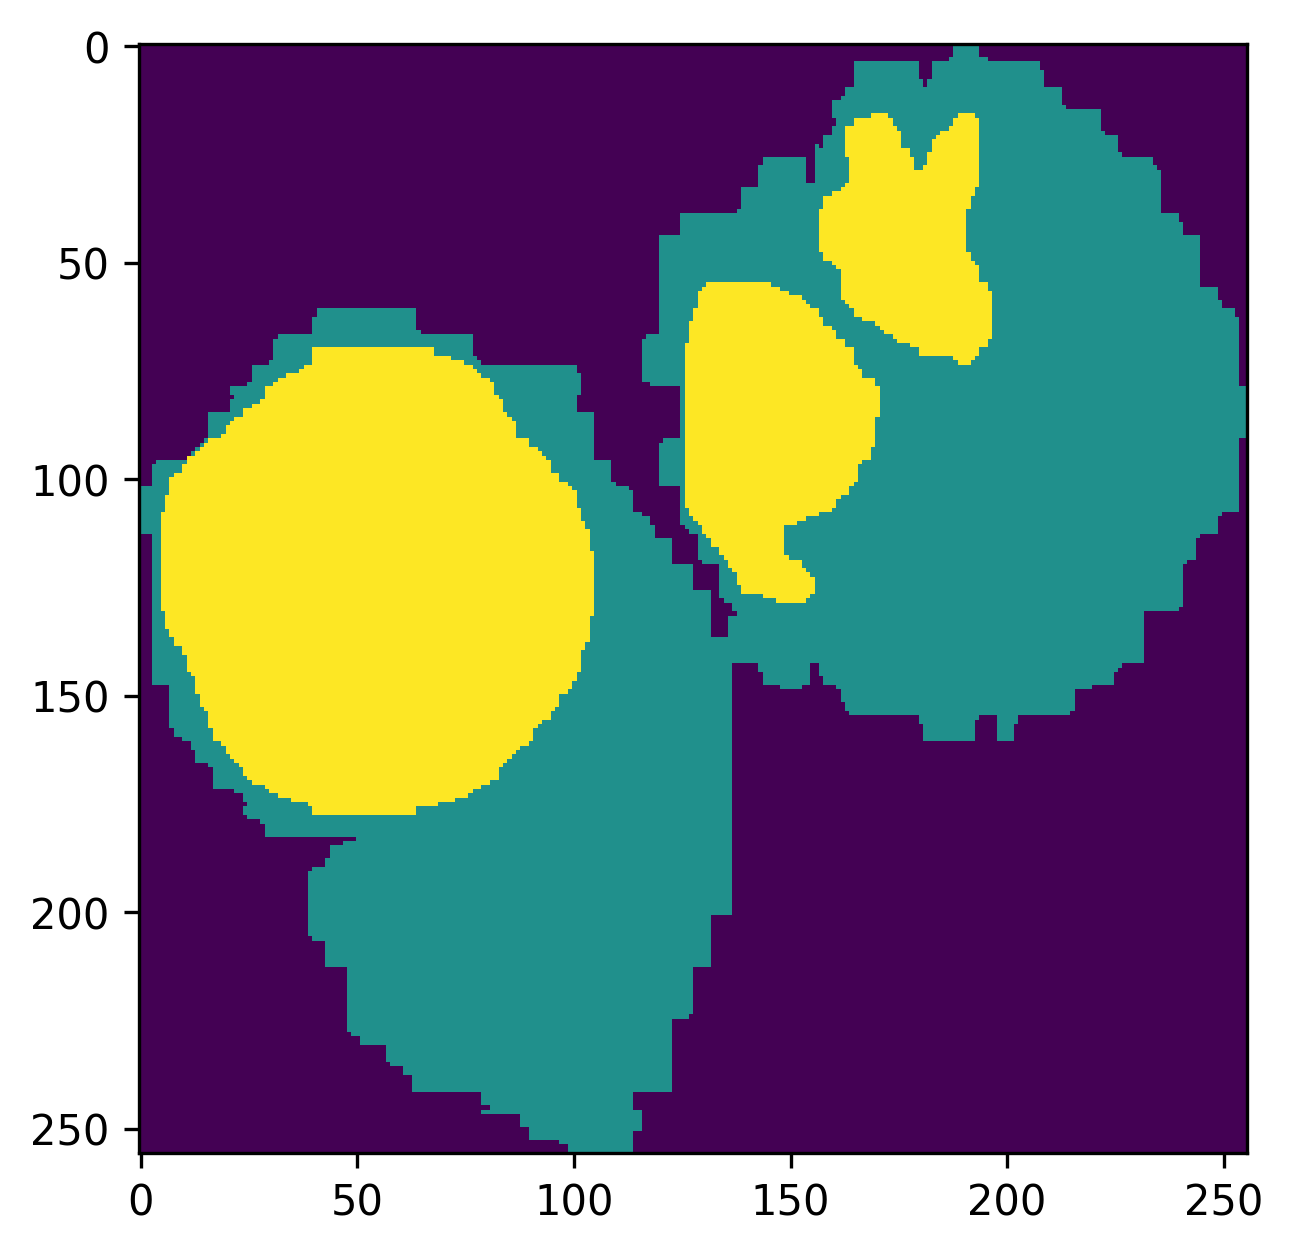

In [45]:
#get fake images and append to orignal X_train and Y_train
my_X_train, my_X_test, my_Y_train, my_Y_test = train_test_split(X_train, Y_train, test_size=0.5, random_state=42)
#my_Y_test is the respective labels for the fake cells.
plt.imshow(my_Y_train[0])

In [46]:
import glob
from torchvision import transforms
from PIL import Image

image_paths = sorted(glob.glob("fake_cells_train/*_fake_B.png"))

image_tf = transforms.Compose([transforms.ToTensor(),])

fake_images = [image_tf(Image.open(p)) for p in image_paths]

X_fake = torch.stack(fake_images)
Y_fake = my_Y_test

print("X_fake shape:", X_fake.shape) #should be (N, 3, 256, 256)

#combine
X_train_with_fake = torch.cat([X_train, X_fake], dim=0)
Y_train_with_fake = torch.cat([Y_train, Y_fake], dim=0)

print("X_train_with_fake shape:", X_train_with_fake.shape) #should be (160+80, 3, 256, 256), 

X_fake shape: torch.Size([80, 3, 256, 256])
X_train_with_fake shape: torch.Size([240, 3, 256, 256])


In [47]:
#train TransuNet with train+fake dataset
torch.cuda.empty_cache()
start_time = time.time()
model, best_model_loss=train_model_transunet(X_train_with_fake,Y_train_with_fake,X_val,Y_val, lr= 0.003, momentum= 0.9, weight_decay= 0.01)
end_time = time.time()
print("Total training time:", end_time-start_time)

y_val_pred=make_predictions_transunet(X_val,model=None)
y_val_pred_lbls=y_val_pred.argmax(1)
print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))
#print loss
print("Training loss:", best_model_loss)

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Flatten prediction: shape (B, C, H, W) → (N, C)
y_val_pred_flat = y_val_pred.transpose(0, 2, 3, 1).reshape(-1, y_val_pred.shape[1])

# Flatten true labels: shape (B, H, W) → (N,)
y_true = Y_val.numpy().flatten()

# Binarize true labels for multiclass AUROC
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

# Compute AUROC
auroc = roc_auc_score(y_true_binarized, y_val_pred_flat, multi_class='ovr')

print("AUROC:", auroc)

Using device: cuda
Training: Epoch 1, Batch 0, Loss: 1.1
Training: Epoch 1, Batch 1, Loss: 1.105
Training: Epoch 1, Batch 2, Loss: 1.103
Training: Epoch 1, Batch 3, Loss: 1.106
Training: Epoch 1, Batch 4, Loss: 1.095
Training: Epoch 1, Batch 5, Loss: 1.099
Training: Epoch 1, Batch 6, Loss: 1.101
Training: Epoch 1, Batch 7, Loss: 1.085
Training: Epoch 1, Batch 8, Loss: 1.094
Training: Epoch 1, Batch 9, Loss: 1.09
Training: Epoch 1, Batch 10, Loss: 1.089
Training: Epoch 1, Batch 11, Loss: 1.089
Training: Epoch 1, Batch 12, Loss: 1.087
Training: Epoch 1, Batch 13, Loss: 1.081
Training: Epoch 1, Batch 14, Loss: 1.082
Training: Epoch 1, Batch 15, Loss: 1.085
Training: Epoch 1, Batch 16, Loss: 1.083
Training: Epoch 1, Batch 17, Loss: 1.083
Training: Epoch 1, Batch 18, Loss: 1.075
Training: Epoch 1, Batch 19, Loss: 1.067
Training: Epoch 1, Batch 20, Loss: 1.075
Training: Epoch 1, Batch 21, Loss: 1.067
Training: Epoch 1, Batch 22, Loss: 1.071
Training: Epoch 1, Batch 23, Loss: 1.058
Training: 

c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_l

Loading model from: ./seg_models\best_transunet_model.pkl
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    937035
           1       0.92      0.84      0.88   1187442
           2       0.73      0.88      0.80    496963

    accuracy                           0.89   2621440
   macro avg       0.87      0.89      0.88   2621440
weighted avg       0.90      0.89      0.89   2621440

Training loss: 0.245191290974617
AUROC: 0.9791740003419669


In [ ]:
#now train with train+fake, augmented
X_train_aug_fake, Y_train_aug_fake = augment_train(X_train_with_fake, Y_train_with_fake, augment_times=2)

print("X_train_aug shape:", X_train_aug_fake.shape)
print("Y_train_aug shape:", Y_train_aug_fake.shape)

#X_train,Y_train,X_val,Y_val=load_imgs_labels()
#model=train_model_transunet(X_train,Y_train,X_val,Y_val)
start_time = time.time()
model, best_model_loss=train_model_transunet(X_train_aug_fake,Y_train_aug_fake,X_val,Y_val, lr= 0.003, momentum= 0.9, weight_decay= 0.01)
end_time = time.time()
print("Total training time:", end_time-start_time)
y_val_pred=make_predictions_transunet(X_val,model=None)
y_val_pred_lbls=y_val_pred.argmax(1)
print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))
#print loss
print("Training loss:", best_model_loss)


# Flatten prediction: shape (B, C, H, W) → (N, C)
y_val_pred_flat = y_val_pred.transpose(0, 2, 3, 1).reshape(-1, y_val_pred.shape[1])

# Flatten true labels: shape (B, H, W) → (N,)
y_true = Y_val.numpy().flatten()

# Binarize true labels for multiclass AUROC
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])

# Compute AUROC
auroc = roc_auc_score(y_true_binarized, y_val_pred_flat, multi_class='ovr')

print("AUROC:", auroc)

c:\Python312\Lib\site-packages\torch\nn\functional.py:4969: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
c:\Python312\Lib\site-packages\torch\nn\functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Augmented X shape: torch.Size([720, 3, 256, 256]), Augmented Y shape: torch.Size([720, 256, 256])
X_train_aug shape: torch.Size([720, 3, 256, 256])
Y_train_aug shape: torch.Size([720, 256, 256])
Using device: cuda
Training: Epoch 1, Batch 0, Loss: 1.101
Training: Epoch 1, Batch 1, Loss: 1.119
Training: Epoch 1, Batch 2, Loss: 1.097
Training: Epoch 1, Batch 3, Loss: 1.109
Training: Epoch 1, Batch 4, Loss: 1.093
Training: Epoch 1, Batch 5, Loss: 1.095
Training: Epoch 1, Batch 6, Loss: 1.103
Training: Epoch 1, Batch 7, Loss: 1.107
Training: Epoch 1, Batch 8, Loss: 1.096
Training: Epoch 1, Batch 9, Loss: 1.097
Training: Epoch 1, Batch 10, Loss: 1.097
Training: Epoch 1, Batch 11, Loss: 1.094
Training: Epoch 1, Batch 12, Loss: 1.091
Training: Epoch 1, Batch 13, Loss: 1.097
Training: Epoch 1, Batch 14, Loss: 1.094
Training: Epoch 1, Batch 15, Loss: 1.093
Training: Epoch 1, Batch 16, Loss: 1.084
Training: Epoch 1, Batch 17, Loss: 1.084
Training: Epoch 1, Batch 18, Loss: 1.076
Training: Epoch 1

c:\Users\Chris\Documents\MasterProject590\code\demos\Project2\semseg_functions.py:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_l

Loading model from: ./seg_models\best_transunet_model.pkl
              precision    recall  f1-score   support

           0       0.98      0.95      0.96    937035
           1       0.92      0.86      0.89   1187442
           2       0.75      0.92      0.83    496963

    accuracy                           0.90   2621440
   macro avg       0.88      0.91      0.89   2621440
weighted avg       0.91      0.90      0.90   2621440

Training loss: 0.22307865023612977


Follow this tutorial: https://github.com/jlevy44/medstudent_resident_informatics_tutorials/blob/main/1_image_analysis/2_image_segmentation.ipynb

# Load specimens data

In [ ]:
sps=pd.read_pickle("specimens_toy_data.pkl")

In [ ]:
df=pd.concat([sps[k]["metadata"].assign(class_=lambda x: k) for k in sps])
df["class_"]=pd.Categorical(df["class_"],["neg","aty","sus","pos"])
    #["nc_ratio"]

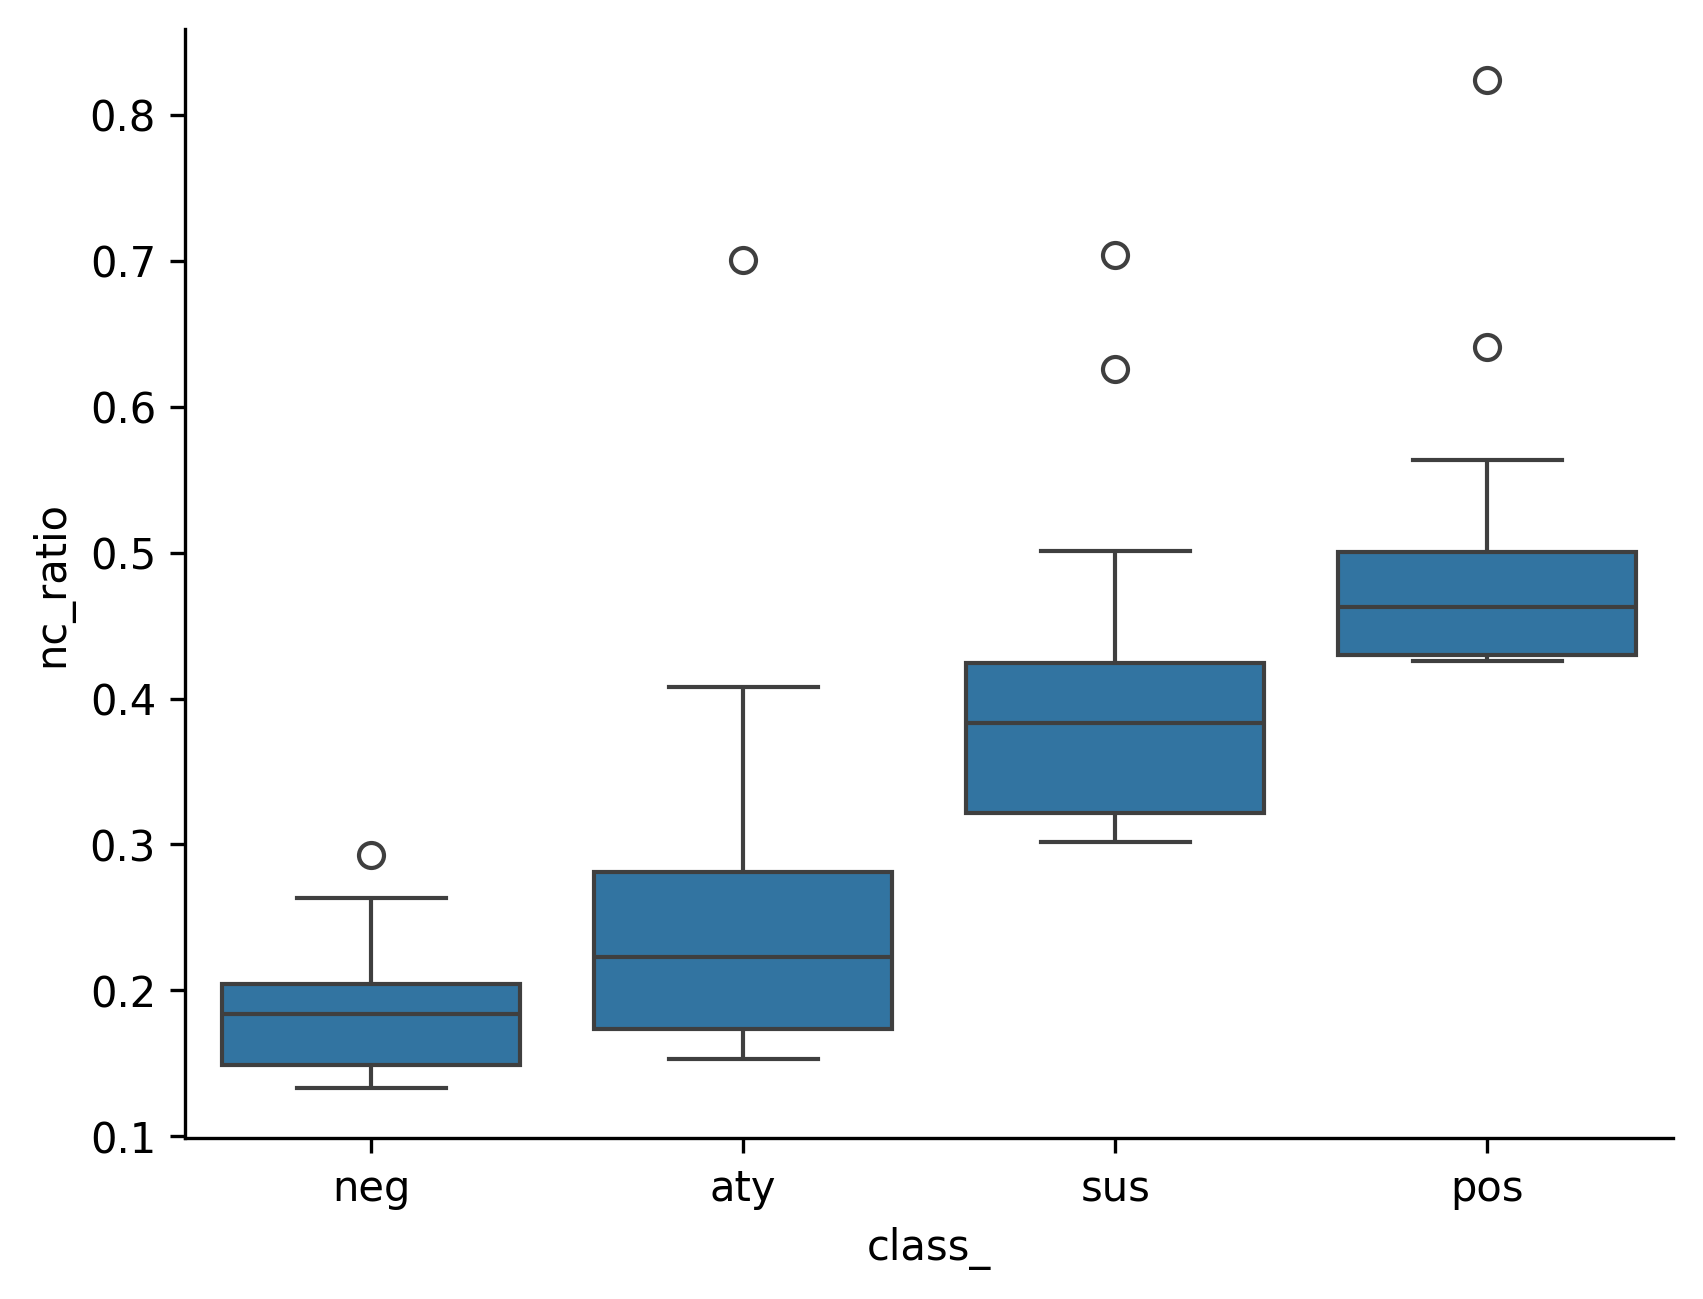

In [ ]:
sns.boxplot(x="class_",y="nc_ratio",data=df)
sns.despine()

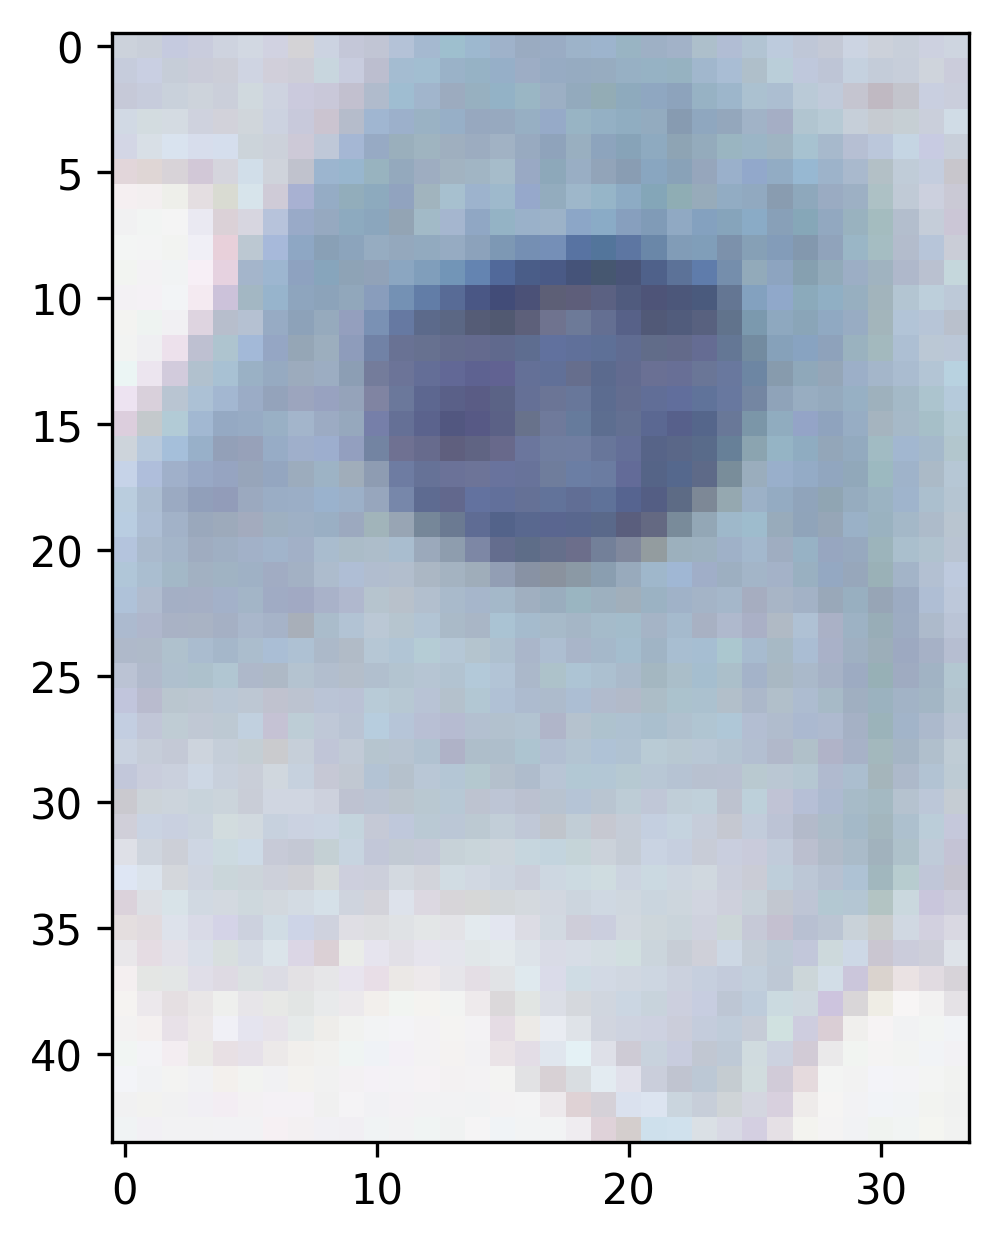

In [ ]:
plt.imshow(sps["neg"]["imgs"][0])

In [ ]:
from functools import reduce
resize = lambda x: cv2.resize(x,(256,256),interpolation=cv2.INTER_CUBIC)
all_images=reduce(lambda x,y: x+y,[list(map(resize,sps[k]["imgs"])) for k in sps])

In [ ]:
# describes above images, assess performance for NC ratio, class assignment, etc
df.head(df.shape[0])

,aty,nc_ratio,nuclear_area,cyto_area,class_
0,0.057022,0.141928,7221.0,43657.0,neg
1,0.037513,0.175625,7597.0,35660.0,neg
2,0.056971,0.150782,7442.0,41914.0,neg
3,0.077020,0.182437,8177.0,36644.0,neg
4,0.111039,0.183712,8696.0,38639.0,neg
...,...,...,...,...,...
20,0.143248,0.359070,16533.0,29511.0,sus
21,0.079847,0.304277,14783.0,33801.0,sus
22,0.519353,0.424544,21172.0,28698.0,sus
23,0.498367,0.386391,15150.0,24059.0,sus


In [ ]:
print(df)

         aty  nc_ratio  nuclear_area  cyto_area class_
0   0.057022  0.141928        7221.0    43657.0    neg
1   0.037513  0.175625        7597.0    35660.0    neg
2   0.056971  0.150782        7442.0    41914.0    neg
3   0.077020  0.182437        8177.0    36644.0    neg
4   0.111039  0.183712        8696.0    38639.0    neg
..       ...       ...           ...        ...    ...
20  0.143248  0.359070       16533.0    29511.0    sus
21  0.079847  0.304277       14783.0    33801.0    sus
22  0.519353  0.424544       21172.0    28698.0    sus
23  0.498367  0.386391       15150.0    24059.0    sus
24  0.226941  0.327733       14786.0    30330.0    sus

[100 rows x 5 columns]


In [ ]:
print(sps.keys())
#print nested keys
print(sps["neg"].keys())
#print shape of imgs
print(sps["neg"]["imgs"][0].shape)
#for all classes
for k in sps:
    print(f"{k} has {len(sps[k]['imgs'])} images")
#print keys for metadata
print(sps["neg"]["metadata"].keys())
#check if classes have keys
print(sps["neg"]["metadata"]["nc_ratio"].keys())

dict_keys(['neg', 'pos', 'aty', 'sus'])
dict_keys(['imgs', 'metadata'])
(44, 34, 3)
neg has 25 images
pos has 25 images
aty has 25 images
sus has 25 images
Index(['aty', 'nc_ratio', 'nuclear_area', 'cyto_area'], dtype='object')
RangeIndex(start=0, stop=25, step=1)


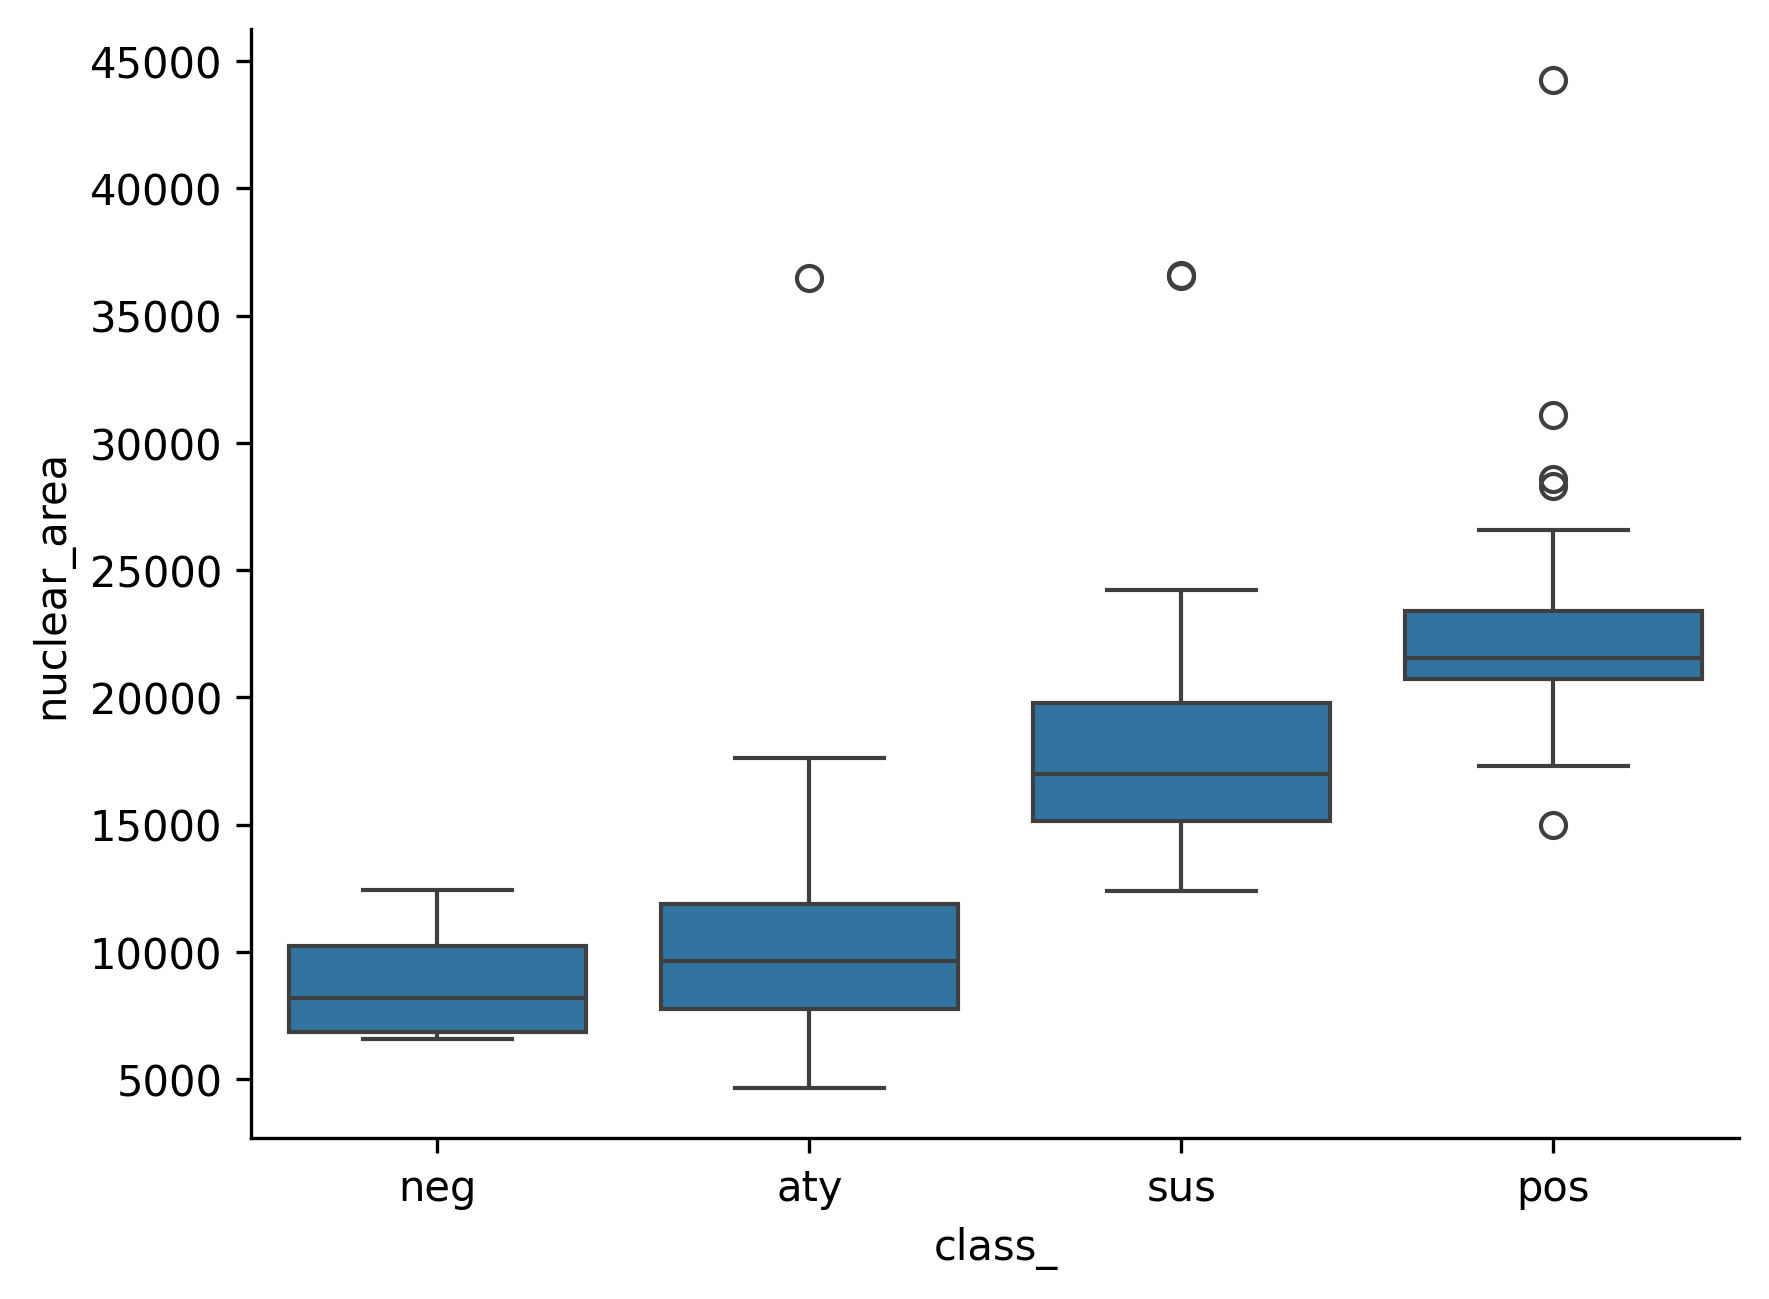

In [ ]:
sns.boxplot(x="class_",y="nuclear_area",data=df)
sns.despine()

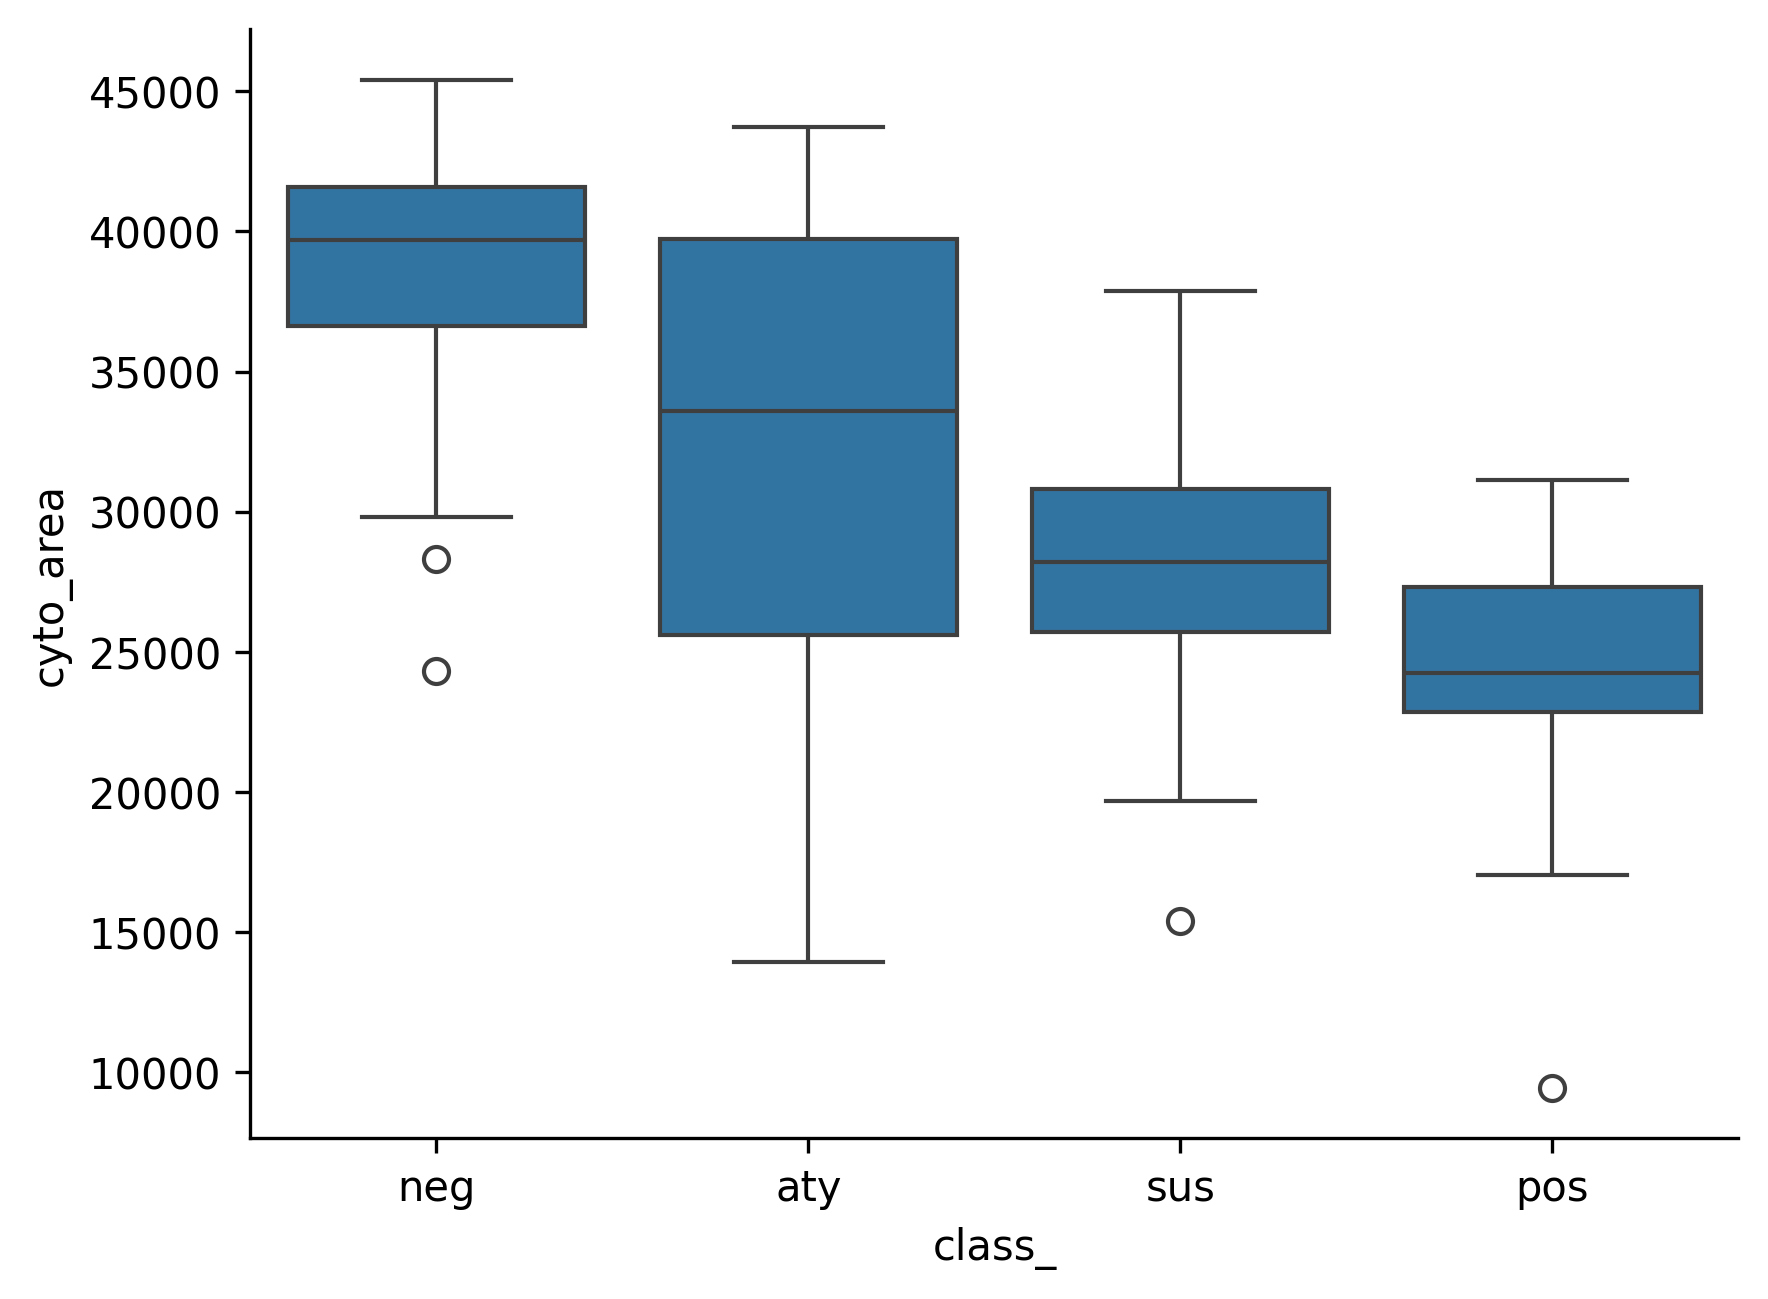

In [ ]:
sns.boxplot(x="class_",y="cyto_area",data=df)
sns.despine()